# Milestone 3 -- Sacramento Kings
## Jie Guo, Chris Chao, Gina Zeng, Cameron Swanson
## 04/16/2022

## Exploratory Data Analysis

This milestone adds onto our previous work from Milestone 2, with some extra insights into customer segmentation, and analysis of potential correlations between ticket purchases/email activity/merchandise purchases.  In addition, the team ran market basket analysis on the merchandise dataset, in an attempt to uncover items that were frequently bought together by different groups of customers.  Finally, a draft of a Tableau dashboard has been made to show various aspects of merchandise sales, including number of purchases by state, the most popular product categories, and monthly sales over time.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.mlab as mlab  
import matplotlib.pyplot as plt 
from pandas import DataFrame, Series
import pandas as pd
from datetime import datetime
from plotly import graph_objects as go
import plotly.graph_objs as go2
from plotly import tools
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.express as px
import plotly
import requests
import mplcursors
import matplotlib
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Merchandise Dataset

We'll begin with the merchandise dataset -- upon reading in our data, we first __drop unnamed columns__.  These are present due to the formatting present in the original Excel worksheet.

In [2]:
merch_df = pd.read_csv("fanatics_2021_subscriber.csv")
merch_df = merch_df.loc[:, ~merch_df.columns.str.match("Unnamed:")]
merch_df.head()

OrderID  PartnerSite                PartnerSiteName      Subscriber Key  \
0  175302812         8551  Sacramento Kings Online Store  0031R00001v0pctQAA   
1  171785884         8551  Sacramento Kings Online Store  0031R00001v0pfTQAQ   
2  194914895         8551  Sacramento Kings Online Store  0031R00001v0wDOQAY   
3  197969348         8551  Sacramento Kings Online Store  0031R00001v1635QAA   
4  197969348         8551  Sacramento Kings Online Store  0031R00001v1635QAA   

   EmailOptIn   ClientId   OrderDate ProductCategory ProductSubCategory  \
0           1  249785879   2021/3/17             JER                YTH   
1           1  246732872   2021/1/17             TEE                LAD   
2           1  266849909  2021/11/23             SWT                MEN   
3           1  269612912   2021/12/6             EQU                GOL   
4           1  269612912   2021/12/6             SWT                MEN   

   ProductID  ... ExtendedPrice Order Discount Total Order Subtotal  \
0    4114498  ...       $74.99                $0.00         $74.99    
1    3948454  ...       $19.99                $0.00         $19.99    
2    4178635  ...       $30.00                $0.00         $30.00    
3    4036353  ...       $10.99                $0.00         $45.99    
4    4192414  ...       $35.00                $0.00         $45.99    

  OrderTaxableSubTotal OrderNonTaxableSubTotal OrderTaxTotal OrderTotal  \
0              $74.99                   $0.00         $6.51     $90.48    
1              $19.99                   $0.00         $2.43     $31.40    
2              $30.00                   $0.00         $2.48     $41.46    
3              $45.99                   $0.00         $3.48     $51.46    
4              $45.99                   $0.00         $3.48     $51.46    

  OrderShipTotal OrderTotalPaidByAccount  OrderTotalPaidByFancash  
0         $6.99                   $0.00                    $0.00   
1         $6.99                   $0.00                    $0.00   
2         $6.99                   $0.00                    $0.00   
3         $0.00                   $0.00                    $0.00   
4         $0.00                   $0.00                    $0.00   

[5 rows x 31 columns]

In [3]:
merch_df.shape

(7249, 31)

In [4]:
merch_df.columns

Index(['OrderID', 'PartnerSite', 'PartnerSiteName', 'Subscriber Key',
       'EmailOptIn', 'ClientId', 'OrderDate', 'ProductCategory',
       'ProductSubCategory', 'ProductID', 'ProductName/Description',
       'ShipAddressCity', 'ShipAddressState', 'ShipAddressCountry',
       'ShipAddressZip', 'BillAddressCity', 'BillAddressState',
       'BillAddressCountry', 'BillAddressZip', 'QuantitySold', 'UnitPrice',
       'ExtendedPrice', 'Order Discount Total', 'Order Subtotal',
       'OrderTaxableSubTotal', 'OrderNonTaxableSubTotal', 'OrderTaxTotal',
       'OrderTotal', 'OrderShipTotal', 'OrderTotalPaidByAccount',
       'OrderTotalPaidByFancash'],
      dtype='object')

The above printouts show our dataset has __7250 line items,__ with __31 different features__, including product details, customer features, and various totals and taxes.

We'll also read in the subscriber key dataset, to merge with our merchandise data.

In [5]:
merch_sub = pd.read_csv("fanatics subscriber keys.csv")
merch_sub.rename(columns={'SubscriberKey':'Subscriber Key'}, inplace = True)
merch_sub.head()

Subscriber Key
0  0031R00001v0pctQAA
1  0031R00001v0pfTQAQ
2  0031R00001v0wDOQAY
3  0031R00001v1635QAA
4  0031R00001v16LtQAI

In [6]:
merch_df = merch_df.merge(merch_sub,on = 'Subscriber Key',how = 'inner')
merch_df.head()

OrderID  PartnerSite                PartnerSiteName      Subscriber Key  \
0  175302812         8551  Sacramento Kings Online Store  0031R00001v0pctQAA   
1  171785884         8551  Sacramento Kings Online Store  0031R00001v0pfTQAQ   
2  194914895         8551  Sacramento Kings Online Store  0031R00001v0wDOQAY   
3  197969348         8551  Sacramento Kings Online Store  0031R00001v1635QAA   
4  197969348         8551  Sacramento Kings Online Store  0031R00001v1635QAA   

   EmailOptIn   ClientId   OrderDate ProductCategory ProductSubCategory  \
0           1  249785879   2021/3/17             JER                YTH   
1           1  246732872   2021/1/17             TEE                LAD   
2           1  266849909  2021/11/23             SWT                MEN   
3           1  269612912   2021/12/6             EQU                GOL   
4           1  269612912   2021/12/6             SWT                MEN   

   ProductID  ... ExtendedPrice Order Discount Total Order Subtotal  \
0    4114498  ...       $74.99                $0.00         $74.99    
1    3948454  ...       $19.99                $0.00         $19.99    
2    4178635  ...       $30.00                $0.00         $30.00    
3    4036353  ...       $10.99                $0.00         $45.99    
4    4192414  ...       $35.00                $0.00         $45.99    

  OrderTaxableSubTotal OrderNonTaxableSubTotal OrderTaxTotal OrderTotal  \
0              $74.99                   $0.00         $6.51     $90.48    
1              $19.99                   $0.00         $2.43     $31.40    
2              $30.00                   $0.00         $2.48     $41.46    
3              $45.99                   $0.00         $3.48     $51.46    
4              $45.99                   $0.00         $3.48     $51.46    

  OrderShipTotal OrderTotalPaidByAccount  OrderTotalPaidByFancash  
0         $6.99                   $0.00                    $0.00   
1         $6.99                   $0.00                    $0.00   
2         $6.99                   $0.00                    $0.00   
3         $0.00                   $0.00                    $0.00   
4         $0.00                   $0.00                    $0.00   

[5 rows x 31 columns]

In [7]:
merch_df.shape

(7248, 31)

After performing the merge, we see that __2 line items have been removed.__

Next, we confirm that our dataset has __no missing values__.

In [8]:
print(merch_df.isnull().any())

OrderID                    False
PartnerSite                False
PartnerSiteName            False
Subscriber Key             False
EmailOptIn                 False
ClientId                   False
OrderDate                  False
ProductCategory            False
ProductSubCategory         False
ProductID                  False
ProductName/Description    False
ShipAddressCity            False
ShipAddressState           False
ShipAddressCountry         False
ShipAddressZip             False
BillAddressCity            False
BillAddressState           False
BillAddressCountry         False
BillAddressZip             False
QuantitySold               False
UnitPrice                  False
ExtendedPrice              False
Order Discount Total       False
Order Subtotal             False
OrderTaxableSubTotal       False
OrderNonTaxableSubTotal    False
OrderTaxTotal              False
OrderTotal                 False
OrderShipTotal             False
OrderTotalPaidByAccount    False
OrderTotal

### Data Type Verification

Our next step is to verify that the __datatypes of each column are correct.__  We can printout each column's datatypes below.

In [9]:
merch_df.dtypes

OrderID                     int64
PartnerSite                 int64
PartnerSiteName            object
Subscriber Key             object
EmailOptIn                  int64
ClientId                    int64
OrderDate                  object
ProductCategory            object
ProductSubCategory         object
ProductID                   int64
ProductName/Description    object
ShipAddressCity            object
ShipAddressState           object
ShipAddressCountry         object
ShipAddressZip             object
BillAddressCity            object
BillAddressState           object
BillAddressCountry         object
BillAddressZip             object
QuantitySold                int64
UnitPrice                  object
ExtendedPrice              object
Order Discount Total       object
Order Subtotal             object
OrderTaxableSubTotal       object
OrderNonTaxableSubTotal    object
OrderTaxTotal              object
OrderTotal                 object
OrderShipTotal             object
OrderTotalPaid

Most of the datatypes look correct -- however, we note that the __price and totals columns are of type "object" (string), rather than "float".__  Also, we note the __"OrderDate" column is also of type "object" rather than a datetime.__  We'll correct these datatypes next.

### Price Column Conversion

In [10]:
price_columns = ["UnitPrice", "ExtendedPrice", "Order Discount Total", "Order Subtotal", "OrderTaxableSubTotal",
                "OrderNonTaxableSubTotal", "OrderTaxTotal", "OrderTotal", "OrderShipTotal", "OrderTotalPaidByAccount",
                "OrderTotalPaidByFancash"]

merch_df[price_columns] = merch_df[price_columns].apply(lambda x:x.str[1:].str.split(",").str.join("")).astype("float")

In [11]:
merch_df["OrderTotal"].head()

0    90.48
1    31.40
2    41.46
3    51.46
4    51.46
Name: OrderTotal, dtype: float64

The above head printout verifies that our conversion was successful.

### Datetime Conversion

In [12]:
merch_df['OrderDate'] = pd.to_datetime(merch_df['OrderDate'])
merch_df['OrderDate']

0      2021-03-17
1      2021-01-17
2      2021-11-23
3      2021-12-06
4      2021-12-06
          ...    
7243   2021-12-08
7244   2021-11-27
7245   2021-11-27
7246   2021-11-27
7247   2021-05-05
Name: OrderDate, Length: 7248, dtype: datetime64[ns]

The above head printout and below `info()` printout confirms that both of our datatype conversions were successful.

In [13]:
merch_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7248 entries, 0 to 7247
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   OrderID                  7248 non-null   int64         
 1   PartnerSite              7248 non-null   int64         
 2   PartnerSiteName          7248 non-null   object        
 3   Subscriber Key           7248 non-null   object        
 4   EmailOptIn               7248 non-null   int64         
 5   ClientId                 7248 non-null   int64         
 6   OrderDate                7248 non-null   datetime64[ns]
 7   ProductCategory          7248 non-null   object        
 8   ProductSubCategory       7248 non-null   object        
 9   ProductID                7248 non-null   int64         
 10  ProductName/Description  7248 non-null   object        
 11  ShipAddressCity          7248 non-null   object        
 12  ShipAddressState         7248 non-

### Define the Product Categories

Next, we explore the __product categories and subcategories present in the dataset.__  Using the product names and descriptions in the dataset, we can define most of the categories and subcategories below.  Colin has also noted that from item to item, some of the categories and subcategories assigned are sometimes inconsistent.

In [14]:
unique_product_categories = merch_df["ProductCategory"].unique()
unique_product_categories

array(['JER', 'TEE', 'SWT', 'EQU', 'SHT', 'SHR', 'ACC', 'SOC', 'TAN',
       'BED', 'SHU', 'HAT', 'COL', 'KID', 'JAC', 'POL', 'CAR', 'PNT',
       'GFT', 'PAN', 'CUP', 'FLA', 'JEW', 'STR', 'OFF', 'DRS', 'BLA',
       'SWE', 'HOM', 'INF', 'SWM', 'AUT'], dtype=object)

__JER:__ Jersey
__TEE:__ Tee Shirt
__HAT:__ Hat
__SHR:__ Shirt
__BED:__ Loungewear/Sleepwear
__ACC:__ Accessories
__TAN:__ Tank Top
__COL:__ Collector's Items
__CUP:__ Drinkware
__SOC:__ Socks
__PNT:__ Pants/Leggings (All Ladies' Items in this Dataset?)
__DRS:__ Dress
__JAC:__ Jacket
__SWT:__ Sweatshirt
__POL:__ Polo Shirt
__SHU:__ Shoes/Sandals/Slippers
__SHT:__ Shorts/Trunks/Boxers
__JEW:__ Jewelry
__INF:__ Infants' Clothing
__KID:__ Children's Clothing
__FLA:__ Flags/Banners
__CAR:__ Car Decorations/Decals/Plate Frames
__SWM:__ Swim Trunks
__BLA:__ Blankets
__GFT:__ Gift Cards
__SWE:__ Sweatbands
__EQU:__ Sports Equipment
__STR:__ Sweaters
__OFF:__ Office Decor
__HOM:__ Home/Man-Cave Decor
__PAN:__ Men's Pants?
__AUT:__ Autographed Items
__SEA:__ Seat Cushion (only one purchase)

### Define the Product Subcategories

In [15]:
unique_product_subcategories = merch_df["ProductSubCategory"].unique()
unique_product_subcategories

array(['YTH', 'LAD', 'MEN', 'GOL', 'MAS', 'UNI', 'PIN', 'INF', 'N-B',
       'TOD', 'KIT', 'WLA', 'GIF', 'STI', 'CRF', 'DAY', 'HOM', 'GLA',
       'BAL', 'MUG', 'FRA', '3X5', 'EQP', 'JUV', 'SEA', 'CEL', 'LUG',
       'SGL', 'EAR', 'TUM', 'CMP', 'KEY', 'BED', 'PLU', 'CRD', 'PHO',
       'CAL', 'BAN', 'LWN', 'AUT', 'GAM', 'MAG', 'TRC', 'GMU', 'KOZ',
       'WAL', 'HAI', 'MIS', 'COI', 'WTB', 'ELE', 'BRC', 'CAS', 'MAT',
       'TIE'], dtype=object)

__MEN:__ Men's
__LAD:__ Ladies'
__YTH:__ Youth
__MAS:__ Masks
__DAY:__ ???
__PIN:__ Pin
__TOD:__ Toddler
__EAR:__ Earrings
__GIF:__ ???
__N-B:__ Newborn
__3X5:__ 3X5 Flags
__FRA:__ License Plate Frames
__UNI:__ Unisex?
__STI:__ Stickers/Decals
__PLU:__ Plush? (Blankets/Throws/Beanies)
__WLA:__ ???
__INF:__ Infant
__CRD:__ Gift Cards
__CEL:__ Cell Phone Accessories
__TUM:__ Tumblers
__JUV:__ Juvenile?
__FIT:__ Fitness? (only a Yoga Mat purchased)
__HOM:__ Home Decor
__GLA:__ Glasses
__BAL:__ Basketballs
__CRF:__ eGift Cards
__BAN:__ Banners
__MAG:__ Car Magnets
__TRC:__ Trading Cards
__GMU:__ Game-Used
__HIT:__ Hitch Covers
__KOZ:__ Coolers
__WTB:__ Water Bottles
__LUG:__ Luggage
__MUG:__ Mugs
__PHO:__ Photos/Plagues/Collages
__WAL:__ Wallets
__CMP:__ Computer Accessories
__BRC:__ Bracelets
__KEY:__ Keychains
__ELE:__ Leather
__GAM:__ Games? (Kids' Ball Set)
__LWN:__ Lawn/Backyard? (Cornhole/Ping-Pong)
__TIE:__ Black Tie/Formal (only Cufflinks)
__CAS:__ Display Cases
__MIS:__ Miscellaneous?? (ProductCategories are FLA and CUP)
__HAI:__ Hair (only headbands)
__SGL:__ Shot Glasses
__AUT:__ Authentic (Custom Jerseys)
__GOL:__ Golf
__SEA:__ Holiday/Seasonal
__CAL:__ Calendars
__MAT:__ Mats
__BED:__ Bedding Accessories
__KIT:__ Kitchen Accessories
__COI:__ Collectors' Coins
__EQP:__ Collectors' Equipment? (Basketballs)
__PK:__ ??? (only one Bleacher Cushion purchased)

## Total Revenue by Month

Next, we looked at the __total revenue__ from merchandise purchases each month.  We needed to `drop_duplicates()` in the "OrderID" column, because for orders with more than one line item, the order total would be displayed in both rows, effectively double counting each order total.

In [16]:
unique_orders = merch_df.drop_duplicates(subset=["OrderID"])
per_month=unique_orders.resample('M', on='OrderDate').agg({'OrderTotal':'sum', "QuantitySold": "sum"})
permonth = pd.DataFrame({'Month':per_month.index, 'OrderTotal':per_month.OrderTotal, "QuantitySold": per_month.QuantitySold})
permonth = permonth.reset_index(drop='True')
permonth.Month=permonth.Month.astype(np.str)
permonth["Month"] = pd.Series(["January 2021", "February 2021", "March 2021", "April 2021", "May 2021", "June 2021", "July 2021",
                              "August 2021", "September 2021", "October 2021", "November 2021", "December 2021"])
permonth

Month  OrderTotal  QuantitySold
0     January 2021    35580.09           425
1    February 2021    30083.63           319
2       March 2021    32594.47           338
3       April 2021    13276.67           189
4         May 2021     7723.73           115
5        June 2021     5821.91            69
6        July 2021     6367.02            87
7      August 2021    12056.60           145
8   September 2021    13429.37           176
9     October 2021    44658.86           439
10   November 2021   135462.28          1239
11   December 2021    76969.39           981

### Total Purchases and Revenue by State

Below is a similar calculation for __total revenue__, broken down by state.

In [17]:
group_by_state = unique_orders.groupby('ShipAddressState')
states_sales = group_by_state['OrderTotal', "QuantitySold"].agg('sum')
states_sales = states_sales.sort_values(by="OrderTotal", ascending=[False])
states_sales.head(5)

<ipython-input-17-a364dcedb840>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



OrderTotal  QuantitySold
ShipAddressState                          
CA                 370729.02          4072
NV                   5313.31            51
DE                   3347.40            22
WA                   2693.04            25
OR                   2535.55            34

## Customer Segmentation by Purchase Frequency

Before moving onto visualization, our last step is to __segment our customer base__ by purchase frequency, separating one-time buyers from frequent buyers and so on.  We can do this below by tracking the __unique orders__ that were placed by each customer, and then label each group using the defined cutoffs.

In [18]:
merch_df_freq = merch_df.drop_duplicates("OrderID").groupby('Subscriber Key')['OrderID'].count()   # count how many a subscriber purchased merchandise, no matter how many seats in each purchase, only count times of purchase
merch_df_freq = merch_df_freq.to_frame().reset_index()
merch_df_freq.describe(include="all")

Subscriber Key      OrderID
count                 3411  3411.000000
unique                3411          NaN
top     0033600000SflC3AAJ          NaN
freq                     1          NaN
mean                   NaN     1.220170
std                    NaN     0.660501
min                    NaN     1.000000
25%                    NaN     1.000000
50%                    NaN     1.000000
75%                    NaN     1.000000
max                    NaN    13.000000

<AxesSubplot:ylabel='Customer Type'>

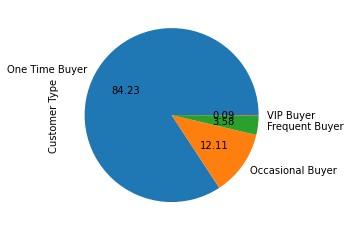

In [19]:
def label_m(row):
    if row['OrderID'] == 1:
        val = 'One Time Buyer'
    elif row['OrderID'] >= 2 and row['OrderID'] < 3:     
        val = 'Occasional Buyer'
    elif row['OrderID'] >= 3 and row['OrderID'] <= 10:
        val = 'Frequent Buyer'
    else:
        val = 'VIP Buyer'
    return val

merch_df_freq['Customer Type'] = merch_df_freq.apply(label_m, axis=1)
merch_df_freq['Customer Type'].value_counts().plot(kind='pie', autopct="%.2f")

We can see that nearly 85% of the customers from 2021 are only __one-time buyers__ -- meanwhile, only about 0.1% of customers are VIPs with __more than 10 unique orders per year__.

We'll use these customer groups in our data visualization section to find out where these sales are coming from.

## Data Visualization

### Top 10 Categories by Total Purchases

For our first visualization, we analyzed the __top 10 product categories based on total number of purchases.__  We can see that __tee shirts__ are the most popular product by a significant margin, with a significantly steep drop-off below the top 3 products (tee shirts, jerseys, and sweatshirts).

Text(0.5, 1.0, 'Top 10 Product Categories by Total Purchases -- 2021')

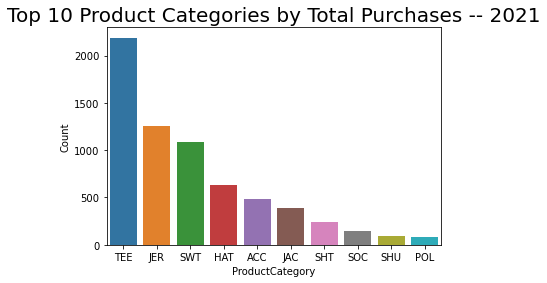

In [20]:
%matplotlib inline
total_purchases_by_category = merch_df.groupby(["ProductCategory"])["ProductCategory"].count().sort_values(ascending=False).to_frame()
total_purchases_by_category.columns = ["Count"]
total_purchases_by_category = total_purchases_by_category.reset_index()
total_purchases_by_category = total_purchases_by_category.sort_values(by=["Count"], ascending=False)[0:10]
ax = sns.barplot(x="ProductCategory", y="Count", data=total_purchases_by_category)
ax.axes.set_title("Top 10 Product Categories by Total Purchases -- 2021", fontsize=20)

### Top 10 States by Total Line Item Purchases (Including CA)

Next, we performed a similar analysis on the __top 10 states by total number of purchases__.  As expected, California dominates the market with over 6000 purchases, a very significant margin above Nevada, the state with the second-most total purchases.  Overall, we see that most of the top states outside of CA are either somewhat neighboring states (NV, OR, WA, ID) or states with large populations (TX, NY), with Wisconsin as an interesting exception.

Text(0.5, 1.0, 'Top 10 States by Total Line Item Purchases - Including CA')

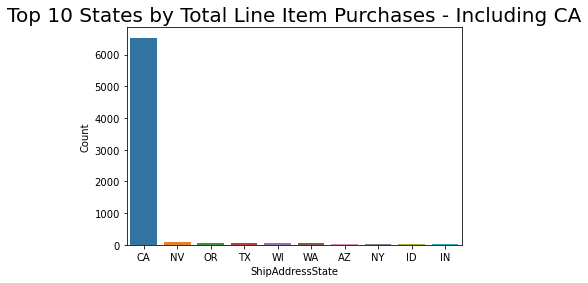

In [21]:
total_purchases_by_state = merch_df.groupby(["ShipAddressState"])["ShipAddressState"].count().to_frame()
total_purchases_by_state.columns = ["Count"]
total_purchases_by_state = total_purchases_by_state.reset_index()
total_purchases_by_state = total_purchases_by_state.sort_values(by=["Count"], ascending=False)
ax = sns.barplot(x="ShipAddressState", y="Count", data=total_purchases_by_state[0:10])
ax.axes.set_title("Top 10 States by Total Line Item Purchases - Including CA", fontsize=20)

### Top 10 States by Total Line Item Purchases (Non-CA)

For better clarity on the non-CA states, we removed California and created the same visualization.  We can now see there is still a significant gap between Nevada, the new leading state, and Oregon and Texas, the next two states down.

Text(0.5, 1.0, 'Top 10 States by Total Line Item Purchases - Non-CA')

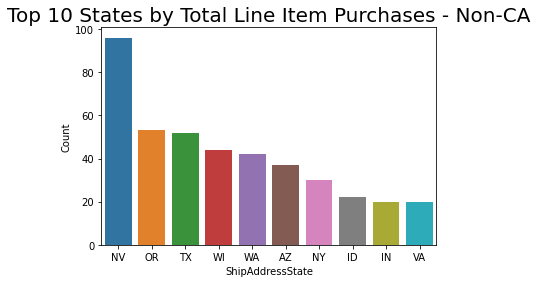

In [22]:
total_purchases_by_state_not_ca = total_purchases_by_state[total_purchases_by_state["ShipAddressState"] != "CA"]
total_purchases_by_state_not_ca = total_purchases_by_state_not_ca.sort_values(by=["Count"], ascending=False)
ax = sns.barplot(x="ShipAddressState", y="Count", data=total_purchases_by_state_not_ca[0:10])
ax.axes.set_title("Top 10 States by Total Line Item Purchases - Non-CA", fontsize=20)

### Percentage of Sales by State (Non-CA)

Our next visualization shows the __percentage of total sales broken down by state,__ once again with the exception of California.  We can see that while Nevada is the single state with the most merchandise sales, we can see the aggregation of all the non-significant states (the "Other States" category) represents __over half of total sales__.  Note that all states are present in this dataset, with the exceptions of __Louisiana, North Dakota, and Vermont.__

In [23]:
States = pd.DataFrame({'states':states_sales.index, 'OrderTotal':states_sales.OrderTotal})
States = States.reset_index(drop='True')
States.states=States.states.astype(np.str)
# Removing CA
out_of_states = States[1:-1]
# Aggregating states with low numbers into "other" category
out_of_states.loc[out_of_states["OrderTotal"] < 1770, "states"] = "Other States" 
location1=out_of_states.groupby('states')
out_of_states=location1['OrderTotal'].agg('sum')
out_of_states = pd.DataFrame({'states':out_of_states.index, 'OrderTotal':out_of_states})
out_of_states = out_of_states.reset_index(drop='True')
out_of_states.states=out_of_states.states.astype(np.str)
out_of_states=out_of_states.sort_values(by=['OrderTotal'],ascending=[False])
states_sales1=out_of_states['OrderTotal'].values

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
pie1_list = states_sales1
labels = out_of_states['states']
# figure
fig = {
  "data": [
    {
      "values": pie1_list,
      "labels": labels,
      "domain": {"x": [1, 1]},
      "name": "sale percentage",
      "hoverinfo":"label+percent+name",
#         "textinfo":'value',
  
#      "textfont_size":20,
      "hole": .2,
      "type": "pie"
    },],
  "layout": {
        "title":"Percentage of Sales by State (Non-CA)",
        "annotations": [
            { "font": { "size": 1.1},
              "showarrow": False,
              "text": "sale percentage",
                "x": 6,
                "y": 1
            },
        ]
    }
}


iplot(fig)

## Customer Segnmentation -- Percentage of Sales by State

Next, we'll create similar visualizations for __percentage of sales by state__, this time factoring in the customer segmentation performed earlier (separating by purchase frequency).  We'll create one chart each for __one-time buyers__, __occasional buyers__, __frequent buyers__, and __VIP buyers__ as we defined earlier.

In [25]:
one_time_buyers = list(merch_df_freq[merch_df_freq["Customer Type"] == "One Time Buyer"]["Subscriber Key"])
low_freq_buyers = list(merch_df_freq[merch_df_freq["Customer Type"] == "Occasional Buyer"]["Subscriber Key"])
high_freq_buyers = list(merch_df_freq[merch_df_freq["Customer Type"] == "Frequent Buyer"]["Subscriber Key"])
vip_buyers = list(merch_df_freq[merch_df_freq["Customer Type"] == "VIP Buyer"]["Subscriber Key"])

merch_one_time_buyers = merch_df[merch_df["Subscriber Key"].isin(one_time_buyers)]
merch_low_freq_buyers = merch_df[merch_df["Subscriber Key"].isin(low_freq_buyers)]
merch_high_freq_buyers = merch_df[merch_df["Subscriber Key"].isin(high_freq_buyers)]
merch_vip_buyers = merch_df[merch_df["Subscriber Key"].isin(vip_buyers)]

### One-Time Buyers

In [26]:
unique_orders_one_time = merch_one_time_buyers.drop_duplicates(subset=["OrderID"])
group_by_state = unique_orders_one_time.groupby('BillAddressState')
states_sales = group_by_state['OrderTotal'].agg('sum')
states_sales = states_sales.sort_values(ascending=[False])

States = pd.DataFrame({'states':states_sales.index, 'OrderTotal':states_sales})
States = States.reset_index(drop='True')
States.states=States.states.astype(np.str)
# Removing CA
out_of_states = States[1:-1]
# Aggregating states with low numbers into "other" category
out_of_states.loc[out_of_states["OrderTotal"] < 1000, "states"] = "Other States"  
location1=out_of_states.groupby('states')
out_of_states=location1['OrderTotal'].agg('sum')
out_of_states = pd.DataFrame({'states':out_of_states.index, 'OrderTotal':out_of_states})
out_of_states = out_of_states.reset_index(drop='True')
out_of_states.states=out_of_states.states.astype(np.str)
out_of_states=out_of_states.sort_values(by=['OrderTotal'],ascending=[False])
states_sales1=out_of_states['OrderTotal'].values

pie1_list = states_sales1
labels = out_of_states['states']
fig = {
  "data": [
    {
      "values": pie1_list,
      "labels": labels,
      "domain": {"x": [1, 1]},
      "name": "sale percentage",
      "hoverinfo":"label+percent+name",
      "hole": .2,
      "type": "pie"
    },],
  "layout": {
        "title":"Percentage of Sales by State (Non-CA, One-Time Buyers)",
        "annotations": [
            { "font": { "size": 1.1},
              "showarrow": False,
              "text": "sale percentage",
                "x": 6,
                "y": 1
            },
        ]
    }
}


iplot(fig)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Occasional Buyers

In [27]:
unique_orders_low_freq = merch_low_freq_buyers.drop_duplicates(subset=["OrderID"])
group_by_state = unique_orders_low_freq.groupby('BillAddressState')
states_sales = group_by_state['OrderTotal'].agg('sum')
states_sales = states_sales.sort_values(ascending=[False])

States = pd.DataFrame({'states':states_sales.index, 'OrderTotal':states_sales})
States = States.reset_index(drop='True')
States.states=States.states.astype(np.str)
# Removing CA
out_of_states = States[1:-1]
# Aggregating states with low numbers into "other" category
out_of_states.loc[out_of_states["OrderTotal"] < 400, "states"] = "Other States"  
location1=out_of_states.groupby('states')
out_of_states=location1['OrderTotal'].agg('sum')
out_of_states = pd.DataFrame({'states':out_of_states.index, 'OrderTotal':out_of_states})
out_of_states = out_of_states.reset_index(drop='True')
out_of_states.states=out_of_states.states.astype(np.str)
out_of_states=out_of_states.sort_values(by=['OrderTotal'],ascending=[False])
states_sales1=out_of_states['OrderTotal'].values

pie1_list = states_sales1
labels = out_of_states['states']
fig = {
  "data": [
    {
      "values": pie1_list,
      "labels": labels,
      "domain": {"x": [1, 1]},
      "name": "sale percentage",
      "hoverinfo":"label+percent+name",
      "hole": .2,
      "type": "pie"
    },],
  "layout": {
        "title":"Percentage of Sales by State (Non-CA, Occasional Buyers)",
        "annotations": [
            { "font": { "size": 1.1},
              "showarrow": False,
              "text": "sale percentage",
                "x": 6,
                "y": 1
            },
        ]
    }
}


iplot(fig)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Frequent Buyers

In [28]:
unique_orders_high_freq = merch_high_freq_buyers.drop_duplicates(subset=["OrderID"])
group_by_state = unique_orders_high_freq.groupby('BillAddressState')
states_sales = group_by_state['OrderTotal'].agg('sum')
states_sales = states_sales.sort_values(ascending=[False])

States = pd.DataFrame({'states':states_sales.index, 'OrderTotal':states_sales})
States = States.reset_index(drop='True')
States.states=States.states.astype(np.str)
# Removing CA
out_of_states = States[1:-1]
# Aggregating states with low numbers into "other" category
# out_of_states.loc[out_of_states["OrderTotal"] < 400, "states"] = "Other States"  
location1=out_of_states.groupby('states')
out_of_states=location1['OrderTotal'].agg('sum')
out_of_states = pd.DataFrame({'states':out_of_states.index, 'OrderTotal':out_of_states})
out_of_states = out_of_states.reset_index(drop='True')
out_of_states.states=out_of_states.states.astype(np.str)
out_of_states=out_of_states.sort_values(by=['OrderTotal'],ascending=[False])
states_sales1=out_of_states['OrderTotal'].values

pie1_list = states_sales1
labels = out_of_states['states']
fig = {
  "data": [
    {
      "values": pie1_list,
      "labels": labels,
      "domain": {"x": [1, 1]},
      "name": "sale percentage",
      "hoverinfo":"label+percent+name",
      "hole": .2,
      "type": "pie"
    },],
  "layout": {
        "title":"Percentage of Sales by State (Non-CA, Frequent Buyers)",
        "annotations": [
            { "font": { "size": 1.1},
              "showarrow": False,
              "text": "sale percentage",
                "x": 6,
                "y": 1
            },
        ]
    }
}


iplot(fig)

### VIP Buyers

In [29]:
unique_orders_vip = merch_vip_buyers.drop_duplicates(subset=["OrderID"])
group_by_state = unique_orders_vip.groupby('BillAddressState')
states_sales = group_by_state['OrderTotal'].agg('sum')
states_sales = states_sales.sort_values(ascending=[False])

States = pd.DataFrame({'states':states_sales.index, 'OrderTotal':states_sales})
States = States.reset_index(drop='True')
States.states=States.states.astype(np.str)

# Aggregating states with low numbers into "other" category
States.loc[States["OrderTotal"] < 400, "states"] = "Other States"  
location1=States.groupby('states')
States=location1['OrderTotal'].agg('sum')
States = pd.DataFrame({'states':States.index, 'OrderTotal':States})
States = States.reset_index(drop='True')
States.states=States.states.astype(np.str)
States=States.sort_values(by=['OrderTotal'],ascending=[False])
states_sales1=States['OrderTotal'].values

pie1_list = states_sales1
labels = States['states']
fig = {
  "data": [
    {
      "values": pie1_list,
      "labels": labels,
      "domain": {"x": [1, 1]},
      "name": "sale percentage",
      "hoverinfo":"label+percent+name",
      "hole": .2,
      "type": "pie"
    },],
  "layout": {
        "title":"Percentage of Sales by State (VIP Buyers)",
        "annotations": [
            { "font": { "size": 1.1},
              "showarrow": False,
              "text": "sale percentage",
                "x": 6,
                "y": 1
            },
        ]
    }
}


iplot(fig)

We can see that __all our VIP customers are based in California__.  Another interesting observation lies in the __occasional bueyrs__ chart -- we see that the state with the highest percentage of sales is __Delaware__, a small state on the East Coast (low population, quite far from the Kings' home base of California).  This is an interesting outlier -- Delaware is considered to be a tax haven for many companies, with lighter taxes, and slightly friendlier corporate laws.  Therefore, these purchases might be traced to corporate accounts (whether for sponsorship deals or other reasons).  We could recommend that the Kings provide discounts to these groups to drive more sales.

## Percentage of CA Sales by Zipcode

Next, we'll isolate all sales in California, and filter their sales breakdown by __zipcode__.  This will allow the team to get a better idea about the customers that are closer to the Golden 1 Center.

In [30]:
CA = merch_df.loc[(merch_df['ShipAddressState']=='CA')]
unique_orders_CA = CA.drop_duplicates(subset=["OrderID"])
unique_orders_CA.ShipAddressZip = [x[:3]for x in unique_orders_CA['ShipAddressZip']]
unique_orders_CA = unique_orders_CA[['ShipAddressZip','OrderTotal']]
group_by_zipcode = unique_orders_CA.groupby('ShipAddressZip')
zipcode_sales = group_by_zipcode['OrderTotal'].agg('sum')
zipcode_sales = zipcode_sales.sort_values(ascending=[False])
zipcode_sales = pd.DataFrame({'zipcode':zipcode_sales.index, 'OrderTotal':zipcode_sales.values})
zipcode_sales = zipcode_sales.sort_values(by=['OrderTotal'],ascending=[False])

zipcode_sales.loc[zipcode_sales["OrderTotal"] < 10000, "zipcode"] = "Other zipcode" 
location1 = zipcode_sales.groupby('zipcode')
zipcode_sales1 = location1['OrderTotal'].agg('sum')
zipcode_sales1 = pd.DataFrame({'zipcode':zipcode_sales1.index, 'OrderTotal':zipcode_sales1.values})
zipcode_sales1 = zipcode_sales1.sort_values(by=['OrderTotal'],ascending=[False])

pie_list = zipcode_sales1.OrderTotal
labels = zipcode_sales1['zipcode']

fig = {
  "data": [
    {
      "values": pie_list,
      "labels": labels,
      "domain": {"x": [1, 1]},
      "name": "sale percentage",
      "hoverinfo":"label+percent+name",
      "hole": .2,
      "type": "pie"
    },],
  "layout": {
        "title":"The sales percentage of CA Zipcode",
        "annotations": [
            { "font": { "size": 1.1},
              "showarrow": False,
              "text": "sale percentage",
                "x": 6,
                "y": 1
            },
        ]
    }
}


iplot(fig)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We can see the most sales are coming from zipcodes beginning with __958, 956, and 957__, all of which are around the greater Sacramento area.  Representation then drops off quite quickly, but we can also see representation from __945__ zip codes, which start around the Napa area, and extend south into Contra Costa county.

### Total Sales and Purchases Over Time (2021)

Our next visualization shows the trends of __total sales and items purchased monthly throughout 2021.__  We can see a slump in activity throughout the summer, with a __significant surge__ starting in the fall and peaking in November 2021.

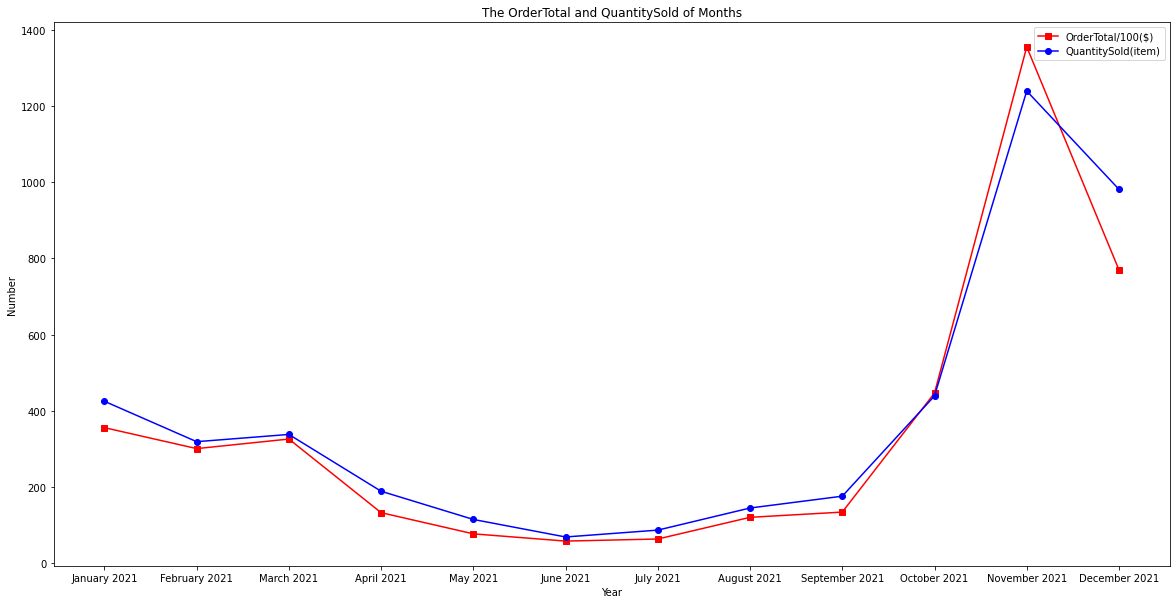

In [31]:
x = permonth['Month']
k1 = permonth['OrderTotal']/100
k2 = permonth['QuantitySold']
plt.plot(x,k1,'s-',color = 'r',label="OrderTotal/100($)")
plt.plot(x,k2,'o-',color = 'b',label="QuantitySold(item)")
plt.xlabel("Year")
plt.ylabel("Number")
plt.title('The OrderTotal and QuantitySold of Months')
plt.legend(loc = "best")
plt.gcf().set_size_inches(20, 10)
plt.show()

### Top 10 Individual Products by Total Purchases

The last visualization for this dataset shows the __total purchases, broken down by individual product__.  We can see in the preceding table, that most of the top 10 products are tee shirts and jerseys -- the exception to this is __face masks__, the 5th most popular product.

In [32]:
Productid=merch_df.groupby('ProductID')
the_sales_products=Productid['QuantitySold'].agg('sum')
the_sales_products=the_sales_products.sort_values(ascending=[False])
the_sales_products = the_sales_products.to_frame()
the_sales_products = pd.DataFrame({'ProductID':the_sales_products.index, 'QuantitySold':the_sales_products.QuantitySold})
the_sales_products = the_sales_products.reset_index(drop='True')
the_sales_products.ProductID=the_sales_products.ProductID.astype(np.str)
the_sales_products = the_sales_products.sort_values(by=['QuantitySold'],ascending=[False])
the_sales_products = the_sales_products[0:10]
product_id_name = merch_df[["ProductID", "ProductName/Description"]]
the_sales_products["ProductID"] = the_sales_products["ProductID"].astype("float")
the_sales_products = the_sales_products.merge(product_id_name, how="left", left_on="ProductID", right_on="ProductID")
the_sales_products = the_sales_products.drop_duplicates(subset=["ProductID"])
the_sales_products

ProductID  QuantitySold  \
0    4115244.0           113   
109  4250982.0           112   
207  4251137.0            97   
301  4115184.0            83   
378  3935223.0            80   
445  4251138.0            76   
521  4192414.0            71   
572  4180989.0            57   
627  4162260.0            56   
680  4214852.0            56   

                               ProductName/Description  
0    Men's New Era Black Sacramento Kings 2020/21 C...  
109  Men's Nike Black Sacramento Kings 2021/22 Swin...  
207  Men's Nike De'Aaron Fox Black Sacramento Kings...  
301  Men's New Era Black Sacramento Kings 2020/21 C...  
378  Adult Fanatics Branded Sacramento Kings Team L...  
445  Men's Nike Tyrese Haliburton Black Sacramento ...  
521  Men's Fanatics Branded Heathered Charcoal Sacr...  
572  Men's Nike Black Sacramento Kings 2020/21 City...  
627  Men's Nike Black Sacramento Kings 2021/22 On-C...  
680  Men's Fanatics Branded Tyrese Haliburton Purpl...

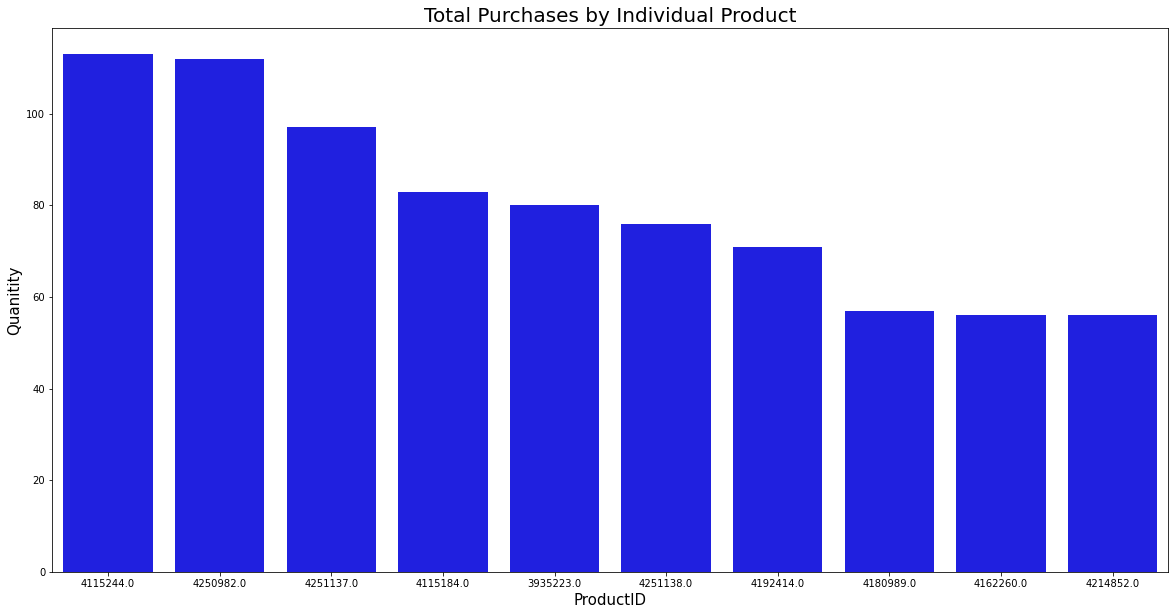

In [33]:
productid = the_sales_products.ProductID

OrderTotal_productid = the_sales_products['QuantitySold']

sns.barplot(x = "ProductID", y = "QuantitySold", data=the_sales_products, 
            order=the_sales_products.sort_values(["QuantitySold"], ascending=False)["ProductID"],
           color = "blue")
plt.ylabel('Quanitity', fontsize=15)
plt.xlabel('ProductID', fontsize=15)
plt.title('Total Purchases by Individual Product', fontsize=20)
plt.gcf().set_size_inches(20, 10)

plt.show()

## Ticket Sales and Email Datasets

Moving on to the __ticket sales, email, and form datasets__ -- we read everything in, and check for missing values in each dataset.

In [34]:
email_clicks = pd.read_csv('fanatics_emails_clicks.csv')
email_open = pd.read_csv('fanatics_emails_open.csv')
email_sent = pd.read_csv('fanatics_emails_sent.csv')
form_sub = pd.read_csv('fanatics_forms_submitted.csv')
ticket_pur = pd.read_csv('Fanatics_Ticket Purchases Since 2018-19.csv')

In [35]:
form_sub.isnull().sum()

SUBSCRIBERKEY    0
CREATEDATE       0
FORMNAME         0
dtype: int64

In [36]:
email_sent.isnull().sum()

SUBSCRIBERKEY    0
SENDID           0
EVENTTYPE        0
SUBJECT          0
EMAILNAME        0
SENTTIME         0
dtype: int64

In [37]:
email_open.isnull().sum()

SUBSCRIBERKEY    0
SENDID           0
EVENTTYPE        0
SUBJECT          0
EMAILNAME        0
SENTTIME         0
EVENTDATE        0
dtype: int64

In [38]:
email_clicks.isnull().sum()

SUBSCRIBERKEY    0
SENDID           0
EVENTTYPE        0
SUBJECT          0
EMAILNAME        0
SENTTIME         0
EVENTDATE        0
dtype: int64

In [39]:
ticket_pur.isnull().sum()

ID                       0
PLANEVENTNAME         6662
EVENTNAME                0
SECTIONNAME              0
ROWNAME                  0
FIRSTSEAT                0
NUMBEROFSEATS            0
BLOCKPURCHASEPRICE       0
PRICECODE                0
EVENTDATE                0
SEASONNAME               0
dtype: int64

Everything looks good, except for the __"PLANEVENTNAME" column__ in the tickets dataset.  However, Colin noted to us that a null value in that column indicated that the purchase was related to __a single game, rather than season tickets.__  Thus, to correct these missing values, we converted this column into a column of integers, with a value of 1 for __season ticket purchases__, and a value of 0 for __single ticket purchases.__

In [40]:
ticket_pur['PLANEVENTNAME'] = ticket_pur['PLANEVENTNAME'].fillna(0)
ticket_pur.loc[ticket_pur["PLANEVENTNAME"] != 0, "PLANEVENTNAME"] = 1
ticket_pur["PLANEVENTNAME"].unique()

array([1, 0], dtype=object)

The above printout shows our conversion was successful.

Next, we'll look at the summary statistics of our form dataset, noting a total of __3388 records__.

In [41]:
form_sub.describe(include='all')

SUBSCRIBERKEY                     CREATEDATE           FORMNAME
count                 3388                           3388               3388
unique                 820                           3388                 68
top     0031R000026TKqAQAW  2022-02-21 18:20:44.193 -0500  Fan Frenzy Sweeps
freq                    59                              1                618

## Email Dataset Summaries -- Splitting Datetime Column

Next, we'll look at summary statistics for all 3 email datasets -- __sent, opened, and clicked emails.__  In each dataset, we'll be splitting the "SENTTIME" column into two different columns for ease of use later.

### Sent Emails

We note __227,000 records__ in this dataset -- this should be the largest of the three, because any email opened or clicked must also have been sent.  Therefore, the other two datasets must be a subset of this one.

In [42]:
email_sent.describe(include='all')

SUBSCRIBERKEY         SENDID EVENTTYPE  \
count               227361  227361.000000    227361   
unique                2759            NaN         1   
top     0033600000SgKd0AAF            NaN      Sent   
freq                   622            NaN    227361   
mean                   NaN  378804.463839       NaN   
std                    NaN  150896.388328       NaN   
min                    NaN  108875.000000       NaN   
25%                    NaN  207201.000000       NaN   
50%                    NaN  421811.000000       NaN   
75%                    NaN  520819.000000       NaN   
max                    NaN  567598.000000       NaN   

                                                  SUBJECT  \
count                                              227361   
unique                                               1249   
top     ?? Today's The Day, %%=v(@subject)=%% - Black ...   
freq                                                 1805   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                EMAILNAME                       SENTTIME  
count                              227361                         227361  
unique                               2118                           2180  
top     101221-KSS-Kings-Game-HSProtocols  2019-11-27 12:43:00.000 -0500  
freq                                 1721                           1138  
mean                                  NaN                            NaN  
std                                   NaN                            NaN  
min                                   NaN                            NaN  
25%                                   NaN                            NaN  
50%                                   NaN                            NaN  
75%                                   NaN                            NaN  
max                                   NaN                            NaN

### Splitting Sent Date/Time into Different Columns

In [43]:
email_sent['SENTTIME'] = email_sent['SENTTIME'].str.split('.').str[0]
email_sent['SENTDAY'] = pd.to_datetime(email_sent['SENTTIME']).dt.date
email_sent.head()

SUBSCRIBERKEY  SENDID EVENTTYPE  \
0  0033600000SfXkeAAF  108875      Sent   
1  0033600000SgKd0AAF  108875      Sent   
2  0033600000SgSo1AAF  109730      Sent   
3  0033600000SfASaAAN  109730      Sent   
4  0033600000SfaE8AAJ  109730      Sent   

                                            SUBJECT  \
0  Important WWE SmackDown Live Parking Information   
1  Important WWE SmackDown Live Parking Information   
2                       ????Less than a month away!   
3                       ????Less than a month away!   
4                       ????Less than a month away!   

                                           EMAILNAME             SENTTIME  \
0  060419 Arena.WWE SmackDown Live Parking Inform...  2019-06-04 19:43:00   
1  060419 Arena.WWE SmackDown Live Parking Inform...  2019-06-04 19:43:00   
2             060719 KI. Kings Insider Newsletter #1  2019-06-07 16:16:00   
3             060719 KI. Kings Insider Newsletter #1  2019-06-07 16:16:00   
4             060719 KI. Kings Insider Newsletter #1  2019-06-07 16:16:00   

      SENTDAY  
0  2019-06-04  
1  2019-06-04  
2  2019-06-07  
3  2019-06-07  
4  2019-06-07

### Opened Emails

As expected, we see only __178,000 records__ in this dataset, less than the dataset of sent emails.

In [44]:
email_open.describe(include='all')

SUBSCRIBERKEY         SENDID EVENTTYPE  \
count               178472  178472.000000    178472   
unique                2356            NaN         1   
top     0033600000SgQDrAAN            NaN      Open   
freq                  2328            NaN    178472   
mean                   NaN  386278.801347       NaN   
std                    NaN  147974.228732       NaN   
min                    NaN  108875.000000       NaN   
25%                    NaN  218558.000000       NaN   
50%                    NaN  425605.000000       NaN   
75%                    NaN  521414.000000       NaN   
max                    NaN  567598.000000       NaN   

                                                SUBJECT  \
count                                            178472   
unique                                             1214   
top     Your Guide to?Health & Safety at Upcoming Games   
freq                                               2129   
mean                                                NaN   
std                                                 NaN   
min                                                 NaN   
25%                                                 NaN   
50%                                                 NaN   
75%                                                 NaN   
max                                                 NaN   

                                EMAILNAME                       SENTTIME  \
count                              178472                         178472   
unique                               1969                           2039   
top     101221-KSS-Kings-Game-HSProtocols  2020-11-23 19:13:00.000 -0500   
freq                                 2129                           1200   
mean                                  NaN                            NaN   
std                                   NaN                            NaN   
min                                   NaN                            NaN   
25%                                   NaN                            NaN   
50%                                   NaN                            NaN   
75%                                   NaN                            NaN   
max                                   NaN                            NaN   

                            EVENTDATE  
count                          178472  
unique                         176084  
top     2022-01-19 20:27:23.000 -0500  
freq                                5  
mean                              NaN  
std                               NaN  
min                               NaN  
25%                               NaN  
50%                               NaN  
75%                               NaN  
max                               NaN

### Splitting the SENTTIME Column

In [45]:
email_open['SENTTIME'] = email_open['SENTTIME'].str.split('.').str[0]
email_open['SENTDAY'] = pd.to_datetime(email_open['SENTTIME']).dt.date
email_open.head()

SUBSCRIBERKEY  SENDID EVENTTYPE  \
0  0033600000SgKd0AAF  108875      Open   
1  0033600000XDZDMAA5  109730      Open   
2  0033600000SfTmJAAV  109730      Open   
3  0031R000026TNC3QAO  109730      Open   
4  0033600000SfwmsAAB  109730      Open   

                                            SUBJECT  \
0  Important WWE SmackDown Live Parking Information   
1                       ????Less than a month away!   
2                       ????Less than a month away!   
3                       ????Less than a month away!   
4                       ????Less than a month away!   

                                           EMAILNAME             SENTTIME  \
0  060419 Arena.WWE SmackDown Live Parking Inform...  2019-06-04 19:43:00   
1             060719 KI. Kings Insider Newsletter #1  2019-06-07 16:16:00   
2             060719 KI. Kings Insider Newsletter #1  2019-06-07 16:16:00   
3             060719 KI. Kings Insider Newsletter #1  2019-06-07 16:16:00   
4             060719 KI. Kings Insider Newsletter #1  2019-06-07 16:16:00   

                       EVENTDATE     SENTDAY  
0  2019-06-05 01:43:58.000 -0400  2019-06-04  
1  2019-07-22 19:30:21.000 -0400  2019-06-07  
2  2019-06-08 14:28:15.000 -0400  2019-06-07  
3  2019-06-10 02:04:39.000 -0400  2019-06-07  
4  2019-06-10 17:27:26.000 -0400  2019-06-07

### Clicked Emails

Finally, we see only __24,000__ records in this dataset, the smallest dataset of the three -- as expected.

In [46]:
email_clicks.describe(include='all')

SUBSCRIBERKEY         SENDID EVENTTYPE  \
count                24928   24928.000000     24928   
unique                1635            NaN         1   
top     0033600000SgE43AAF            NaN     Click   
freq                   381            NaN     24928   
mean                   NaN  392492.740733       NaN   
std                    NaN  149169.053138       NaN   
min                    NaN  109730.000000       NaN   
25%                    NaN  218002.750000       NaN   
50%                    NaN  443542.000000       NaN   
75%                    NaN  520819.000000       NaN   
max                    NaN  567598.000000       NaN   

                                                  SUBJECT  \
count                                               24928   
unique                                                994   
top     ?? Today's The Day, %%=v(@subject)=%% - Black ...   
freq                                                  370   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                              EMAILNAME                       SENTTIME  \
count                             24928                          24928   
unique                             1480                           1531   
top     011522-STM-Member-Gift-Comp-Tix  2022-01-18 17:44:00.000 -0500   
freq                                238                            238   
mean                                NaN                            NaN   
std                                 NaN                            NaN   
min                                 NaN                            NaN   
25%                                 NaN                            NaN   
50%                                 NaN                            NaN   
75%                                 NaN                            NaN   
max                                 NaN                            NaN   

                            EVENTDATE  
count                           24928  
unique                          24885  
top     2022-03-07 16:21:45.000 -0500  
freq                                2  
mean                              NaN  
std                               NaN  
min                               NaN  
25%                               NaN  
50%                               NaN  
75%                               NaN  
max                               NaN

### Splitting the SENTTIME Column

In [47]:
email_clicks['SENTTIME'] = email_clicks['SENTTIME'].str.split('.').str[0]
email_clicks['SENTDAY'] = pd.to_datetime(email_clicks['SENTTIME']).dt.date
email_clicks.head()

SUBSCRIBERKEY  SENDID EVENTTYPE                      SUBJECT  \
0  0033600001VEjSEAA1  109730     Click  ????Less than a month away!   
1  0033600000Sf88yAAB  109730     Click  ????Less than a month away!   
2  0033600000SgE43AAF  109730     Click  ????Less than a month away!   
3  0033600000SgFQBAA3  109730     Click  ????Less than a month away!   
4  0033600001VEjSEAA1  109730     Click  ????Less than a month away!   

                                EMAILNAME             SENTTIME  \
0  060719 KI. Kings Insider Newsletter #1  2019-06-07 16:16:00   
1  060719 KI. Kings Insider Newsletter #1  2019-06-07 16:16:00   
2  060719 KI. Kings Insider Newsletter #1  2019-06-07 16:16:00   
3  060719 KI. Kings Insider Newsletter #1  2019-06-07 16:16:00   
4  060719 KI. Kings Insider Newsletter #1  2019-06-07 16:16:00   

                       EVENTDATE     SENTDAY  
0  2019-06-07 18:50:19.000 -0400  2019-06-07  
1  2019-06-10 00:02:47.000 -0400  2019-06-07  
2  2019-06-09 09:14:25.000 -0400  2019-06-07  
3  2019-06-07 20:57:48.000 -0400  2019-06-07  
4  2019-06-07 18:48:46.000 -0400  2019-06-07

### Tickets Purchased

We also note our __tickets datasets__ contains __34,000__ different orders, spread over __about 1100 unique customers.__

In [48]:
ticket_pur.describe(include='all')

ID  PLANEVENTNAME EVENTNAME SECTIONNAME ROWNAME  \
count                34656        34656.0     34656       34656   34656   
unique                1145            2.0       127          58      42   
top     0031R00002OZkF6QAL            1.0  ESKB0301         113       H   
freq                   523        27994.0       614        1715    2781   
mean                   NaN            NaN       NaN         NaN     NaN   
std                    NaN            NaN       NaN         NaN     NaN   
min                    NaN            NaN       NaN         NaN     NaN   
25%                    NaN            NaN       NaN         NaN     NaN   
50%                    NaN            NaN       NaN         NaN     NaN   
75%                    NaN            NaN       NaN         NaN     NaN   
max                    NaN            NaN       NaN         NaN     NaN   

           FIRSTSEAT  NUMBEROFSEATS  BLOCKPURCHASEPRICE PRICECODE   EVENTDATE  \
count   34656.000000   34656.000000        34656.000000     34656       34656   
unique           NaN            NaN                 NaN      1778         136   
top              NaN            NaN                 NaN      O1K1  2021-12-04   
freq             NaN            NaN                 NaN       563         338   
mean        8.956891       1.987448          236.567089       NaN         NaN   
std         6.932362       0.747806          642.365645       NaN         NaN   
min         1.000000       1.000000            3.600000       NaN         NaN   
25%         3.000000       2.000000           52.000000       NaN         NaN   
50%         7.000000       2.000000          106.000000       NaN         NaN   
75%        13.000000       2.000000          218.000000       NaN         NaN   
max        43.000000      22.000000        19264.000000       NaN         NaN   

                      SEASONNAME  
count                      34656  
unique                         4  
top     2018-19 Kings New Season  
freq                       12028  
mean                         NaN  
std                          NaN  
min                          NaN  
25%                          NaN  
50%                          NaN  
75%                          NaN  
max                          NaN

### Convert EVENTDATE to Datetime

Much like the merchandise dataset above, we need to convert the "EVENTDATE" column to a __datetime format.__

In [49]:
ticket_pur['EVENTDATE'] = pd.to_datetime(ticket_pur['EVENTDATE']).dt.date

To work with the next visualization, we also need to re-convert the "OrderDate" column in the merchandise dataset.

In [50]:
merch_df['OrderDate'] = merch_df['OrderDate'].dt.date

In [51]:
merch_df["OrderDate"].head()

0    2021-03-17
1    2021-01-17
2    2021-11-23
3    2021-12-06
4    2021-12-06
Name: OrderDate, dtype: object

## Data Visualization

### Funnel Chart -- Emails Sent, Opened, and Clicked -- 2018-2022

Our first visualization for these datasets is a __funnel chart__ showing the percentages of __sent emails vs. opened emails vs. clicked emails.__  We can see that of all sent emails, __78\% of those emails were opened__, and __14\% of the opened emails (11\% of the sent emails) were clicked.__

In [52]:
fig = go2.Figure(go2.Funnel(
    y = ["Email Sent", "Email Opened", "Email Clicked"],
    x = [email_sent.SUBSCRIBERKEY.count(),email_open.SUBSCRIBERKEY.count(),email_clicks.SUBSCRIBERKEY.count()],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )

fig.show("notebook")

In [53]:
# Adding column to indicate whether subscriber has purchased a ticket
email_sent['purchased_ticket'] = np.where(email_sent['SUBSCRIBERKEY'].isin(ticket_pur['ID']), 1, 0)
email_open['purchased_ticket'] = np.where(email_open['SUBSCRIBERKEY'].isin(ticket_pur['ID']), 1, 0)
email_clicks['purchased_ticket'] = np.where(email_clicks['SUBSCRIBERKEY'].isin(ticket_pur['ID']), 1, 0)

### Emails Sent, Opened, and Clicked -- Ticket Holders vs. Non-Ticket Holders

A similar funnel chart was created that breaks down the above chart based on __ticket holders vs. non-ticket holders.__  We can see that more ticket holders will click on a sent email, compared to non-ticket holders (14% response rate vs. only 6% response rate).

In [54]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Purchased',
    y = ["Email Sent", "Email Opened", "Email Clicked"],
    x = [sum(i == 1 for i in email_sent['purchased_ticket']),
        sum(i == 1 for i in email_open['purchased_ticket']),
        sum(i == 1 for i in email_clicks['purchased_ticket'])],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = "Haven't Purchased",
    orientation = "h",
    y = ["Email Sent", "Email Opened", "Email Clicked"],
    x = [sum(i == 0 for i in email_sent['purchased_ticket']),
        sum(i == 0 for i in email_open['purchased_ticket']),
        sum(i == 0 for i in email_clicks['purchased_ticket'])],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.show()

### Emails Sent vs. Tickets Purchased vs. Merchandise Purchased

The next three visualizations show the trends between __email activities, tickets purchased, and merchandise purchased.__  The three visualizations are for __sent emails, opened emails, and clicked emails respectively.__

In [55]:
sent_time = email_sent.groupby('SENTDAY').size()
ticket_time = ticket_pur.groupby('EVENTDATE')['NUMBEROFSEATS'].sum()
merchandise_time = merch_df.groupby('OrderDate')['QuantitySold'].sum()

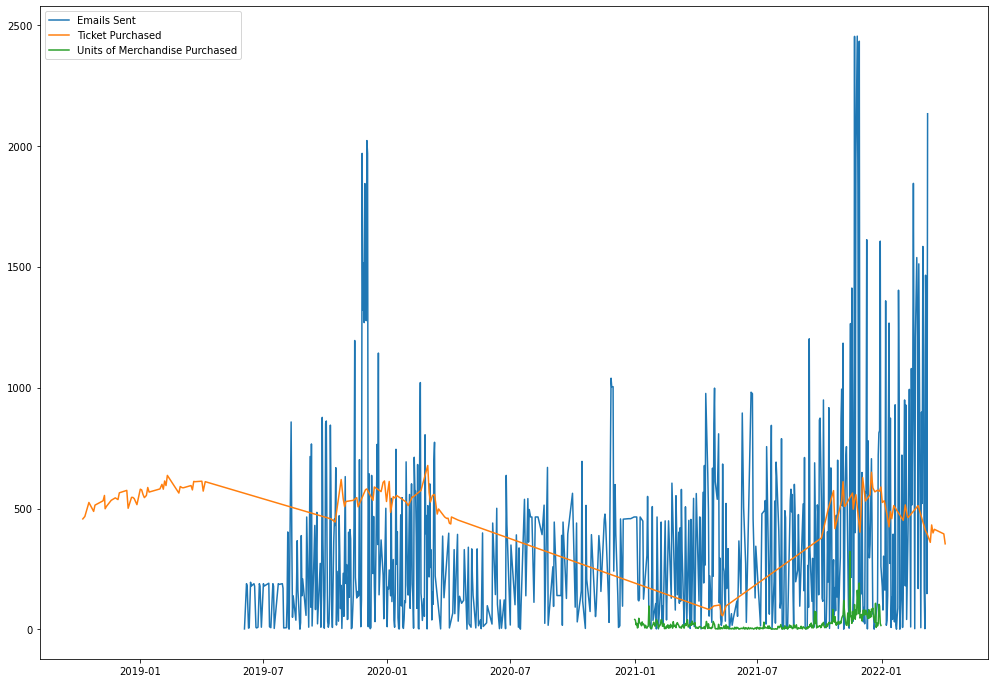

In [56]:
x1 = sent_time.index
y1 = sent_time.values

x2 = ticket_time.index
y2 = ticket_time.values

x3 = merchandise_time.index
y3 = merchandise_time.values
  
f = plt.figure()
f.set_figwidth(17)
f.set_figheight(12)

plt.plot(x1, y1, label = "Emails Sent")
plt.plot(x2, y2, label = "Ticket Purchased")
plt.plot(x3, y3, label = "Units of Merchandise Purchased")
plt.legend()
plt.show()

### Emails Opened vs. Tickets Purchased vs. Merchandise Purchased

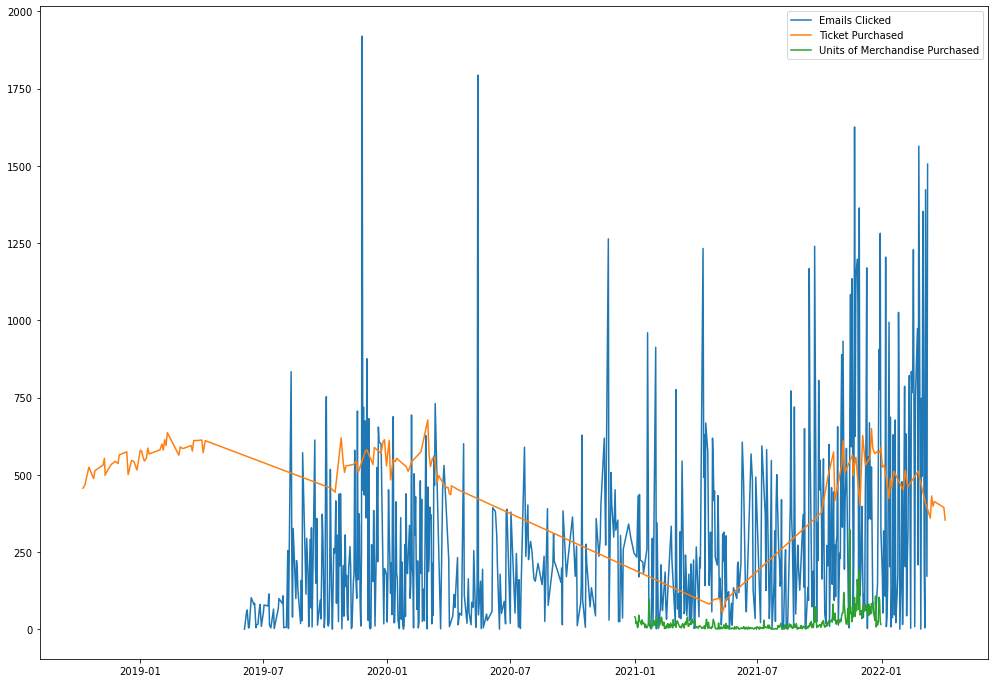

In [57]:
open_time = email_open.groupby('SENTDAY').size()

x1 = open_time.index
y1 = open_time.values

x2 = ticket_time.index
y2 = ticket_time.values

x3 = merchandise_time.index
y3 = merchandise_time.values
  
f = plt.figure()
f.set_figwidth(17)
f.set_figheight(12)

plt.plot(x1, y1, label = "Emails Clicked")
plt.plot(x2, y2, label = "Ticket Purchased")
plt.plot(x3, y3, label = "Units of Merchandise Purchased")
plt.legend()
plt.show()

### Emails Clicked vs. Tickets Purchased vs. Merchandise Purchased

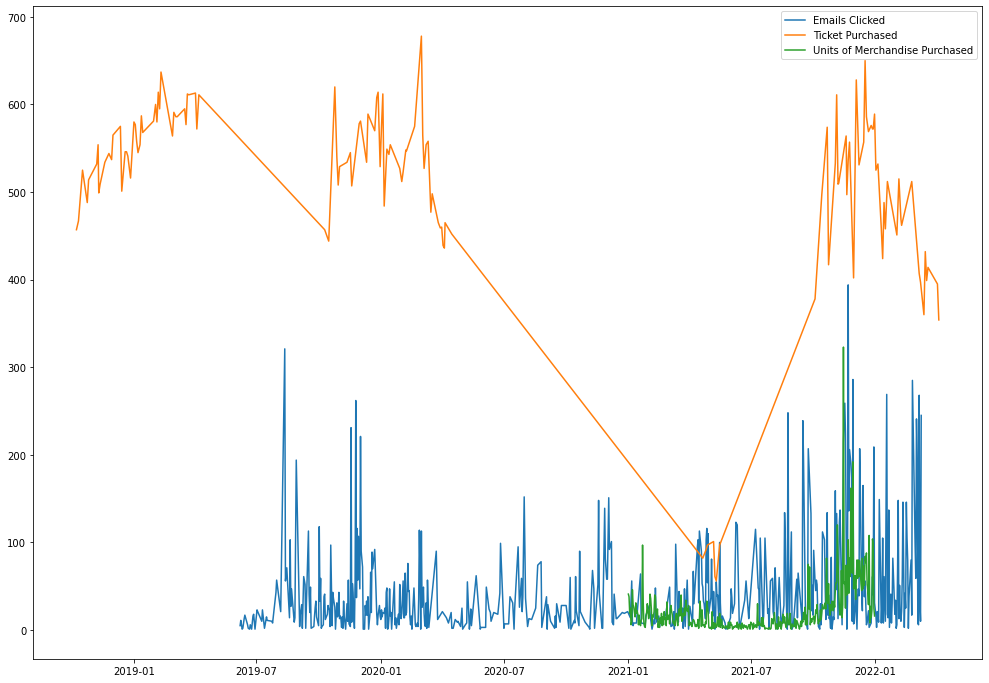

In [58]:
click_time = email_clicks.groupby('SENTDAY').size()

x1 = click_time.index
y1 = click_time.values

x2 = ticket_time.index
y2 = ticket_time.values

x3 = merchandise_time.index
y3 = merchandise_time.values
  
f = plt.figure()
f.set_figwidth(17)
f.set_figheight(12)

plt.plot(x1, y1, label = "Emails Clicked")
plt.plot(x2, y2, label = "Ticket Purchased")
plt.plot(x3, y3, label = "Units of Merchandise Purchased")
plt.legend()
plt.show()

## Customer Segmentation -- Ticket Purchase Frequency

In a similar manner to how we analyzed the merchandise dataset above, we will perform __customer segmentation__ on the ticket and email datasets, obtaining insights on our customer base's distrbution.  We'll first segment by __ticket purchase frequency__, by obtaining number of tickets purchased by customer, and then defining our cutoffs in the function below.

In [59]:
ticket_pur.rename(columns={'ID':'SUBSCRIBERKEY'}, inplace = True)
ticket_freq = ticket_pur.groupby('SUBSCRIBERKEY')['NUMBEROFSEATS'].count()   # count how many a subscriber purchased ticket, no matter how many seats in each purchase, only count times of purchase
ticket_freq = ticket_freq.to_frame().reset_index()
ticket_freq.describe(include='all')

SUBSCRIBERKEY  NUMBEROFSEATS
count                 1145    1145.000000
unique                1145            NaN
top     0033600000SfptgAAB            NaN
freq                     1            NaN
mean                   NaN      30.267249
std                    NaN      62.617765
min                    NaN       1.000000
25%                    NaN       1.000000
50%                    NaN       3.000000
75%                    NaN      18.000000
max                    NaN     523.000000

In [60]:
def label(row):
    if row['NUMBEROFSEATS'] == 1:
        val = 'One Game Watcher'
    elif row['NUMBEROFSEATS'] >= 2 and row['NUMBEROFSEATS'] <= 82:     #How many home games do NBA teams play in a season? - Each team will play 41 away games, and 41 home games. We have 2 yr data
        val = 'Fans / Loyal Fans'
    else:
        val = 'VIP Customer'
    return val

In [61]:
ticket_freq['Customer Type'] = ticket_freq.apply(label, axis=1)
ticket_freq.sort_values(by='NUMBEROFSEATS', ascending=False).head(10)

SUBSCRIBERKEY  NUMBEROFSEATS Customer Type
303  0031R00002OZkF6QAL            523  VIP Customer
707  0033600000SffP2AAJ            473  VIP Customer
539  0033600000SfA1gAAF            463  VIP Customer
347  0031R00002UstnhQAB            348  VIP Customer
669  0033600000SfYq3AAF            308  VIP Customer
936  0033600000Swi5TAAR            305  VIP Customer
534  0033600000Sf88yAAB            284  VIP Customer
863  0033600000SgE43AAF            278  VIP Customer
740  0033600000Sfo2lAAB            274  VIP Customer
855  0033600000SgCPQAA3            271  VIP Customer

<AxesSubplot:title={'center':'Customer Segmentation by Ticket Purchase Frequency'}, ylabel='Customer Type'>

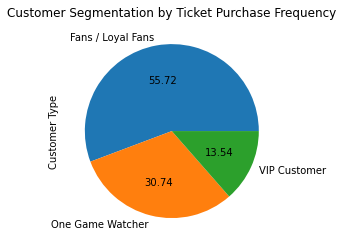

In [62]:
ticket_freq['Customer Type'].value_counts().plot(kind='pie', autopct="%.2f", title="Customer Segmentation by Ticket Purchase Frequency")

We can see that we have __more customers that have attended multiple games, compared to those who only attended one__.  However, we still have about __30% single game attendees__, who are appropriate targets for discounts and promotion deals.

## Customer Segmentation -- Items per Order

Next, we'll segment customers by __average order size__.  Once again, our cutoffs for different groups are defined in the `unit()` function below.

In [63]:
unique_order_quantity = merch_df.groupby(["Subscriber Key", "OrderID"])["QuantitySold"].sum().to_frame()
merchan_unit = unique_order_quantity.groupby('Subscriber Key')['QuantitySold'].mean()
merchan_unit = merchan_unit.to_frame().reset_index()
merchan_unit.describe(include="all")

Subscriber Key  QuantitySold
count                 3411   3411.000000
unique                3411           NaN
top     0033600000SflC3AAJ           NaN
freq                     1           NaN
mean                   NaN      1.840581
std                    NaN      1.572689
min                    NaN      1.000000
25%                    NaN      1.000000
50%                    NaN      1.000000
75%                    NaN      2.000000
max                    NaN     28.000000

In [64]:
def unit(row):
    if row['QuantitySold'] == 1:
        val = 'Single Item Purchaser'
    elif row['QuantitySold'] > 1 and row['QuantitySold'] <= 5:    
        val = 'Small Order Purchaser'
    else:
        val = 'Large Order Purchaser'
    return val

In [65]:
merchan_unit['Customer Type'] = merchan_unit.apply(unit, axis=1)
merchan_unit.describe(include='all')

Subscriber Key  QuantitySold          Customer Type
count                 3411   3411.000000                   3411
unique                3411           NaN                      3
top     0033600000SflC3AAJ           NaN  Single Item Purchaser
freq                     1           NaN                   1849
mean                   NaN      1.840581                    NaN
std                    NaN      1.572689                    NaN
min                    NaN      1.000000                    NaN
25%                    NaN      1.000000                    NaN
50%                    NaN      1.000000                    NaN
75%                    NaN      2.000000                    NaN
max                    NaN     28.000000                    NaN

<AxesSubplot:title={'center':'Customer Segmentation by Average Order Size'}, ylabel='Customer Type'>

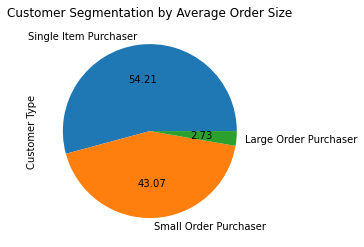

In [66]:
merchan_unit['Customer Type'].value_counts().plot(kind='pie', autopct="%.2f", title="Customer Segmentation by Average Order Size")

As reasonably expected, we see more __single item purchasers__ compared to those who __purchase small orders__.  We also see a small percentage of customers who __purchase large orders__.

## Customer Segmentation -- Total Merchandise Spending

Finally, we'll segment customers by __total spending on merchandise__ -- cutoffs are defined in the `amount()` function below.

In [67]:
merchan_amount = merch_df.groupby('Subscriber Key')['OrderTotal'].sum()   # cal how much in total a subscriber purchase
merchan_amount = merchan_amount.to_frame().reset_index()
merchan_amount.describe(include='all')

Subscriber Key    OrderTotal
count                 3411   3411.000000
unique                3411           NaN
top     0033600000SflC3AAJ           NaN
freq                     1           NaN
mean                   NaN    257.300745
std                    NaN    811.550288
min                    NaN      7.810000
25%                    NaN     65.080000
50%                    NaN    136.780000
75%                    NaN    257.465000
max                    NaN  38893.470000

In [68]:
def amount(row):
    if row['OrderTotal'] < 100:
        val = 'Low Amount Spender'
    elif row['OrderTotal'] >= 100 and row['OrderTotal'] <= 257:     
        val = 'Medium Amount Spender'
    elif row['OrderTotal'] > 257 and row['OrderTotal'] <= 1000:     
        val = 'High Amount Spender'
    else:
        val = 'VIP Purchaser'
    return val

In [69]:
merchan_amount['Customer Type'] = merchan_amount.apply(amount, axis=1)
merchan_amount.describe(include='all')

Subscriber Key    OrderTotal       Customer Type
count                 3411   3411.000000                3411
unique                3411           NaN                   4
top     0033600000SflC3AAJ           NaN  Low Amount Spender
freq                     1           NaN                1402
mean                   NaN    257.300745                 NaN
std                    NaN    811.550288                 NaN
min                    NaN      7.810000                 NaN
25%                    NaN     65.080000                 NaN
50%                    NaN    136.780000                 NaN
75%                    NaN    257.465000                 NaN
max                    NaN  38893.470000                 NaN

<AxesSubplot:title={'center':'Customer Segmentation by Total Merchandise Spending'}, ylabel='Customer Type'>

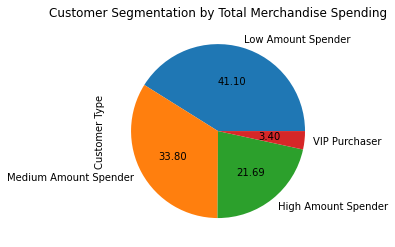

In [70]:
merchan_amount['Customer Type'].value_counts().plot(kind='pie', autopct="%.2f", title="Customer Segmentation by Total Merchandise Spending")

Once again we see that the size of each group decreases as total spending increases, with low spenders in the largest group, and very high spenders (VIPs) in the smallest group.

## Comparing Email and Ticket Trends by Customer Group

Next, we'll analyze the trends of __tickets/merchandise purchases and emails opened over time, filtered by ticket purchase frequency.__  The code to organize our data frames and generate the visualizations is below.

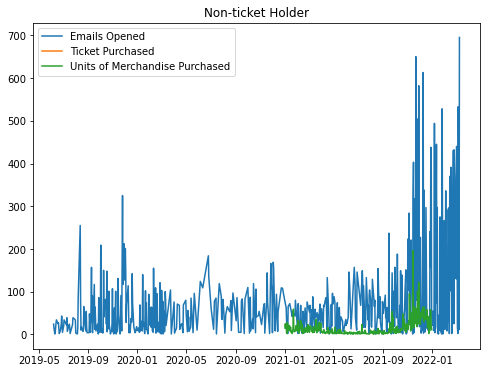

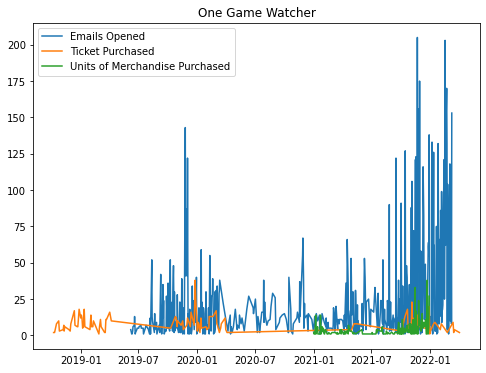

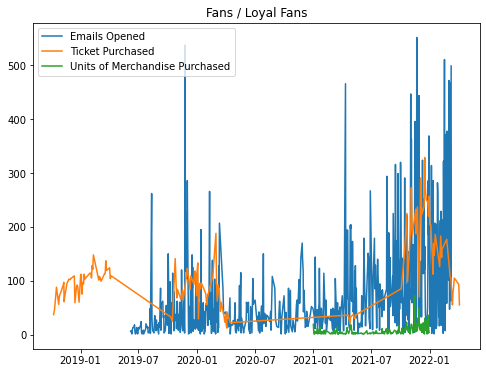

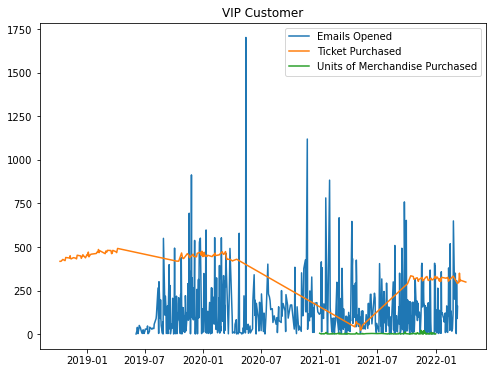

In [71]:
email_open = pd.merge(email_open, ticket_freq, on =['SUBSCRIBERKEY'], how ='left')
email_open['Customer Type'] = email_open['Customer Type'].fillna('Non-ticket Holder')
ticket_pur = pd.merge(ticket_pur, ticket_freq, on ='SUBSCRIBERKEY', how ='left')
ticket_pur['Customer Type'] = ticket_pur['Customer Type'].fillna('Non-ticket Holder')
merch_df = pd.merge(merch_df, ticket_freq, left_on ='Subscriber Key', right_on="SUBSCRIBERKEY", how ='left')
merch_df['Customer Type'] = merch_df['Customer Type'].fillna('Non-ticket Holder')

open_time = email_open.groupby(['Customer Type', 'SENTDAY']).size()
open_time = open_time.to_frame().reset_index()
ticket_time = ticket_pur.groupby(['Customer Type','EVENTDATE'])['NUMBEROFSEATS_x'].sum()
ticket_time = ticket_time.to_frame().reset_index()
merch_time = merch_df.groupby(['Customer Type','OrderDate'])['QuantitySold'].sum()
merch_time = merch_time.to_frame().reset_index()

# Subplot 1

open_time_sub1 = open_time[open_time["Customer Type"] == 'Non-ticket Holder']
x1 = open_time_sub1["SENTDAY"]
y1 = open_time_sub1[0]

ticket_time_sub1 = ticket_time[ticket_time["Customer Type"] == 'Non-ticket Holder']
x2 = ticket_time_sub1["EVENTDATE"]
y2 = ticket_time_sub1['NUMBEROFSEATS_x']

merch_time_sub1 = merch_time[merch_time["Customer Type"] == 'Non-ticket Holder']
x3 = merch_time_sub1["OrderDate"]
y3 = merch_time_sub1["QuantitySold"]

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)

plt.plot(x1, y1, label = "Emails Opened")
plt.plot(x2, y2, label = "Ticket Purchased")
plt.plot(x3, y3, label = "Units of Merchandise Purchased")

plt.title('Non-ticket Holder')
plt.legend()
plt.show()

# Subplot 2

open_time_sub2 = open_time[open_time["Customer Type"] == 'One Game Watcher']
x1 = open_time_sub2["SENTDAY"]
y1 = open_time_sub2[0]

ticket_time_sub2 = ticket_time[ticket_time["Customer Type"] == 'One Game Watcher']
x2 = ticket_time_sub2["EVENTDATE"]
y2 = ticket_time_sub2['NUMBEROFSEATS_x']

merch_time_sub2 = merch_time[merch_time["Customer Type"] == 'One Game Watcher']
x3 = merch_time_sub2["OrderDate"]
y3 = merch_time_sub2["QuantitySold"]

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)

plt.plot(x1, y1, label = "Emails Opened")
plt.plot(x2, y2, label = "Ticket Purchased")
plt.plot(x3, y3, label = "Units of Merchandise Purchased")

plt.title('One Game Watcher')
plt.legend()
plt.show()

# Subplot 3

open_time_sub3 = open_time[open_time["Customer Type"] == 'Fans / Loyal Fans']
x1 = open_time_sub3["SENTDAY"]
y1 = open_time_sub3[0]

ticket_time_sub3 = ticket_time[ticket_time["Customer Type"] == 'Fans / Loyal Fans']
x2 = ticket_time_sub3["EVENTDATE"]
y2 = ticket_time_sub3['NUMBEROFSEATS_x']

merch_time_sub3 = merch_time[merch_time["Customer Type"] == 'Fans / Loyal Fans']
x3 = merch_time_sub3["OrderDate"]
y3 = merch_time_sub3["QuantitySold"]

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)

plt.plot(x1, y1, label = "Emails Opened")
plt.plot(x2, y2, label = "Ticket Purchased")
plt.plot(x3, y3, label = "Units of Merchandise Purchased")

plt.title('Fans / Loyal Fans')
plt.legend()
plt.show()

# Subplot 4

open_time_sub4 = open_time[open_time["Customer Type"] == 'VIP Customer']
x1 = open_time_sub4["SENTDAY"]
y1 = open_time_sub4[0]

ticket_time_sub4 = ticket_time[ticket_time["Customer Type"] == 'VIP Customer']
x2 = ticket_time_sub4["EVENTDATE"]
y2 = ticket_time_sub4['NUMBEROFSEATS_x']

merch_time_sub4 = merch_time[merch_time["Customer Type"] == 'VIP Customer']
x3 = merch_time_sub4["OrderDate"]
y3 = merch_time_sub4["QuantitySold"]

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)

plt.plot(x1, y1, label = "Emails Opened")
plt.plot(x2, y2, label = "Ticket Purchased")
plt.plot(x3, y3, label = "Units of Merchandise Purchased")

plt.title('VIP Customer')
plt.legend()
plt.show()

We can see with each group, as status increases, there seems to be higher correlation between tickets purchased, and emails opened.  The exception is with the VIP customers, where there are generally a high number of tickets purchased at all times, regardless of email activity.

## Merging Email Datasets

Next, we'll merge all three email datasets together, in order to filter __unique email events__, which we'll do next.

In [72]:
email_logs = pd.concat([email_clicks, email_open, email_sent])
email_logs['SENTTIME'] = pd.to_datetime(email_logs['SENTTIME'], errors='coerce', utc=True)
email_logs['EVENTDATE'] = pd.to_datetime(email_logs['EVENTDATE'], errors='coerce', utc=True)
email_logs.head()

SUBSCRIBERKEY  SENDID EVENTTYPE                      SUBJECT  \
0  0033600001VEjSEAA1  109730     Click  ????Less than a month away!   
1  0033600000Sf88yAAB  109730     Click  ????Less than a month away!   
2  0033600000SgE43AAF  109730     Click  ????Less than a month away!   
3  0033600000SgFQBAA3  109730     Click  ????Less than a month away!   
4  0033600001VEjSEAA1  109730     Click  ????Less than a month away!   

                                EMAILNAME                  SENTTIME  \
0  060719 KI. Kings Insider Newsletter #1 2019-06-07 16:16:00+00:00   
1  060719 KI. Kings Insider Newsletter #1 2019-06-07 16:16:00+00:00   
2  060719 KI. Kings Insider Newsletter #1 2019-06-07 16:16:00+00:00   
3  060719 KI. Kings Insider Newsletter #1 2019-06-07 16:16:00+00:00   
4  060719 KI. Kings Insider Newsletter #1 2019-06-07 16:16:00+00:00   

                  EVENTDATE     SENTDAY  purchased_ticket  NUMBEROFSEATS  \
0 2019-06-07 22:50:19+00:00  2019-06-07                 1            NaN   
1 2019-06-10 04:02:47+00:00  2019-06-07                 1            NaN   
2 2019-06-09 13:14:25+00:00  2019-06-07                 1            NaN   
3 2019-06-08 00:57:48+00:00  2019-06-07                 1            NaN   
4 2019-06-07 22:48:46+00:00  2019-06-07                 1            NaN   

  Customer Type  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

## Unique Email Events

Filtering out duplicate events will allow us to view these records from a new angle in our next visualization. 

In [73]:
unique_email_events = email_logs.drop_duplicates(subset = ['SUBSCRIBERKEY', 'SENDID'], keep = 'first').reset_index(drop = True)
unique_email_events.head()

SUBSCRIBERKEY  SENDID EVENTTYPE                      SUBJECT  \
0  0033600001VEjSEAA1  109730     Click  ????Less than a month away!   
1  0033600000Sf88yAAB  109730     Click  ????Less than a month away!   
2  0033600000SgE43AAF  109730     Click  ????Less than a month away!   
3  0033600000SgFQBAA3  109730     Click  ????Less than a month away!   
4  0033600000Sfj03AAB  109830     Click  ????Less than a month away!   

                                EMAILNAME                  SENTTIME  \
0  060719 KI. Kings Insider Newsletter #1 2019-06-07 16:16:00+00:00   
1  060719 KI. Kings Insider Newsletter #1 2019-06-07 16:16:00+00:00   
2  060719 KI. Kings Insider Newsletter #1 2019-06-07 16:16:00+00:00   
3  060719 KI. Kings Insider Newsletter #1 2019-06-07 16:16:00+00:00   
4  060719 KI. Kings Insider Newsletter #2 2019-06-08 14:22:00+00:00   

                  EVENTDATE     SENTDAY  purchased_ticket  NUMBEROFSEATS  \
0 2019-06-07 22:50:19+00:00  2019-06-07                 1            NaN   
1 2019-06-10 04:02:47+00:00  2019-06-07                 1            NaN   
2 2019-06-09 13:14:25+00:00  2019-06-07                 1            NaN   
3 2019-06-08 00:57:48+00:00  2019-06-07                 1            NaN   
4 2019-06-08 19:25:12+00:00  2019-06-08                 1            NaN   

  Customer Type  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

In [74]:
event_count = unique_email_events["EVENTTYPE"].value_counts()
event_count

Sent     137075
Open      75556
Click     14730
Name: EVENTTYPE, dtype: int64

The next visualization is a pie chart depicting the __percentage of sent vs. opened vs. clicked emails__.  It's important to note that due to our earlier filtering, the "Clicked" emails are not shown in the "Sent" or "Open" slices.  So, of all unique emails, __60.3% were sent and ignored__, __33.2% were opened but not acted on__, and __6.5% were acted on__.  This indicates a 6.5% response rate overall.

<AxesSubplot:title={'center':'Count of Unique Email Events -- Sent vs. Open vs. Click'}, ylabel='EVENTTYPE'>

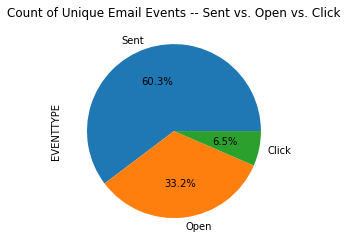

In [75]:
event_count.plot.pie(title="Count of Unique Email Events -- Sent vs. Open vs. Click", autopct='%1.1f%%')

## Email Activity over Time

Next, we're going to visualize subscribers' __email activity over time__.  We'll organize our data and generate visualizations below.

In [76]:
unique_email_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227361 entries, 0 to 227360
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   SUBSCRIBERKEY     227361 non-null  object             
 1   SENDID            227361 non-null  int64              
 2   EVENTTYPE         227361 non-null  object             
 3   SUBJECT           227361 non-null  object             
 4   EMAILNAME         227361 non-null  object             
 5   SENTTIME          227361 non-null  datetime64[ns, UTC]
 6   EVENTDATE         90286 non-null   datetime64[ns, UTC]
 7   SENTDAY           227361 non-null  object             
 8   purchased_ticket  227361 non-null  int32              
 9   NUMBEROFSEATS     50573 non-null   float64            
 10  Customer Type     75556 non-null   object             
dtypes: datetime64[ns, UTC](2), float64(1), int32(1), int64(1), object(6)
memory usage: 18.2+ MB


In [77]:
unique_email_events_count = unique_email_events["EVENTTYPE"].groupby([unique_email_events["SENTTIME"].dt.year, unique_email_events["SENTTIME"].dt.month, unique_email_events["EVENTTYPE"]]).count()
unique_email_events_count = unique_email_events_count.to_frame()
unique_email_events_count.index.names = ['SENTYEAR','SENTMONTH','EVENTTYPE']
unique_email_events_count = unique_email_events_count.rename(columns={"EVENTTYPE": "EVENTCOUNT"})
unique_email_events_count = unique_email_events_count.reset_index()
unique_email_events_count = pd.pivot_table(unique_email_events_count, index=['SENTYEAR','SENTMONTH'], columns='EVENTTYPE', values='EVENTCOUNT')
unique_email_events_count

EVENTTYPE           Click  Open   Sent
SENTYEAR SENTMONTH                    
2019     6             66   319   1139
         7            148   384   1340
         8            526   852   2089
         9            294  1398   3594
         10           480  2504   5424
         11           760  3387  10511
         12           711  2747   8782
2020     1            327  1971   3997
         2            502  2236   6271
         3            336  1749   2747
         4             85   643   1602
         5             83   614   1307
         6            204   923   1410
         7            247  1018   2596
         8            184   740   2201
         9            128   808   1515
         10           214  1022   2188
         11           400  1419   3762
         12           354   968   2463
2021     1            142  1173   2186
         2            118   904   2160
         3            238  1458   3996
         4            698  2338   6195
         5            348  1408   3500
         6            263  1505   3679
         7            378  1716   3942
         8            603  1873   4505
         9            542  1854   3274
         10           660  3273   5272
         11          1818  8263  12525
         12           789  6000   4890
2022     1            629  5599   4526
         2            841  7946   7414
         3            614  4544   4073

<AxesSubplot:title={'center':'Email Activity - 2019-2022'}, xlabel='SENTYEAR,SENTMONTH'>

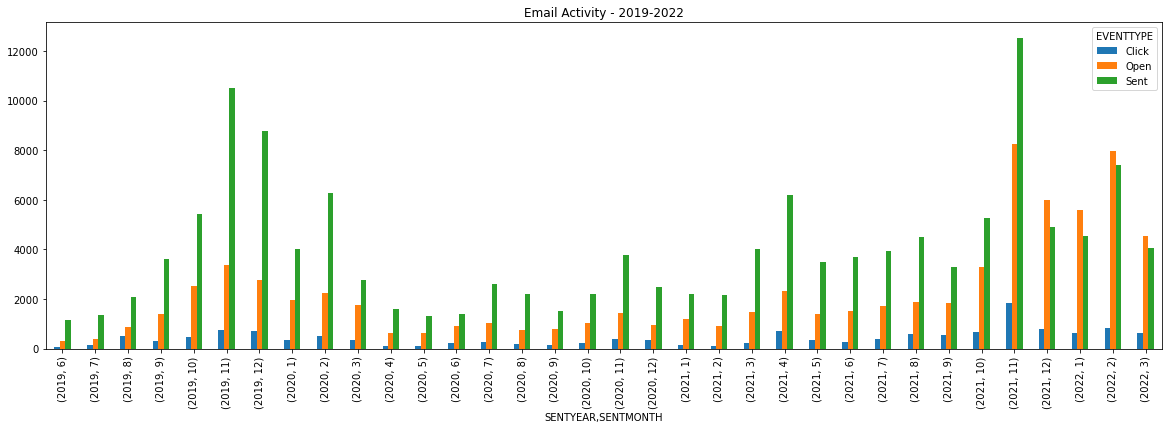

In [78]:
unique_email_events_count.plot.bar(figsize=(20, 6), title="Email Activity - 2019-2022")

We can see around __November 2021__, there is a large spike in activity, and for a time afterwards, __more emails are opened than ignored__.  This may be due to a combination of start-of-season spirit and the anticipation around the general re-opening of facilities.

We can use a __stacked bar chart__ to view this data differently -- we'll accomplish this below.

In [79]:
unique_email_events_count['Total'] = unique_email_events_count[['Click','Open','Sent']].sum(axis = 1)
unique_email_events_count['ClickP'] = unique_email_events_count['Click']/unique_email_events_count['Total']
unique_email_events_count['OpenP'] = unique_email_events_count['Open']/unique_email_events_count['Total']
unique_email_events_count['SentP'] = unique_email_events_count['Sent']/unique_email_events_count['Total']
unique_email_events_count

EVENTTYPE           Click  Open   Sent  Total    ClickP     OpenP     SentP
SENTYEAR SENTMONTH                                                         
2019     6             66   319   1139   1524  0.043307  0.209318  0.747375
         7            148   384   1340   1872  0.079060  0.205128  0.715812
         8            526   852   2089   3467  0.151716  0.245746  0.602538
         9            294  1398   3594   5286  0.055619  0.264472  0.679909
         10           480  2504   5424   8408  0.057088  0.297812  0.645100
         11           760  3387  10511  14658  0.051849  0.231068  0.717083
         12           711  2747   8782  12240  0.058088  0.224428  0.717484
2020     1            327  1971   3997   6295  0.051946  0.313106  0.634948
         2            502  2236   6271   9009  0.055722  0.248196  0.696082
         3            336  1749   2747   4832  0.069536  0.361962  0.568502
         4             85   643   1602   2330  0.036481  0.275966  0.687554
         5             83   614   1307   2004  0.041417  0.306387  0.652196
         6            204   923   1410   2537  0.080410  0.363816  0.555775
         7            247  1018   2596   3861  0.063973  0.263662  0.672365
         8            184   740   2201   3125  0.058880  0.236800  0.704320
         9            128   808   1515   2451  0.052224  0.329661  0.618115
         10           214  1022   2188   3424  0.062500  0.298481  0.639019
         11           400  1419   3762   5581  0.071672  0.254256  0.674073
         12           354   968   2463   3785  0.093527  0.255746  0.650727
2021     1            142  1173   2186   3501  0.040560  0.335047  0.624393
         2            118   904   2160   3182  0.037084  0.284098  0.678818
         3            238  1458   3996   5692  0.041813  0.256149  0.702038
         4            698  2338   6195   9231  0.075615  0.253277  0.671108
         5            348  1408   3500   5256  0.066210  0.267884  0.665906
         6            263  1505   3679   5447  0.048283  0.276299  0.675418
         7            378  1716   3942   6036  0.062624  0.284294  0.653082
         8            603  1873   4505   6981  0.086377  0.268300  0.645323
         9            542  1854   3274   5670  0.095591  0.326984  0.577425
         10           660  3273   5272   9205  0.071700  0.355568  0.572732
         11          1818  8263  12525  22606  0.080421  0.365522  0.554056
         12           789  6000   4890  11679  0.067557  0.513743  0.418700
2022     1            629  5599   4526  10754  0.058490  0.520643  0.420867
         2            841  7946   7414  16201  0.051910  0.490464  0.457626
         3            614  4544   4073   9231  0.066515  0.492254  0.441231

<AxesSubplot:title={'center':'% of Email Activity Type, 2018-2022'}, xlabel='SENTYEAR,SENTMONTH'>

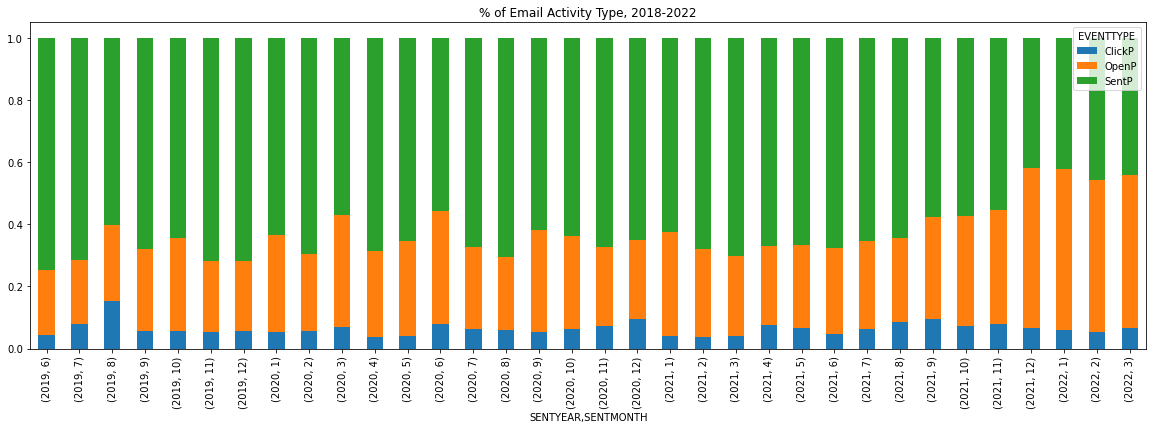

In [80]:
unique_email_events_count[['ClickP','OpenP','SentP']].plot.bar(figsize=(20, 6), stacked=True, title="% of Email Activity Type, 2018-2022")

Once again, we can see the same spike in __opened emails__ around the start of the 2021-22 season.

## Forms Dataset

Returning once again to our forms dataset -- Colin noted that the events of particular note are the __sweepstakes events__, which are noted by the term "Sweeps" in the form name.  We can isolate these events as folows.

In [81]:
forms_df = pd.read_csv("fanatics_forms_submitted.csv")
forms_df['CREATEDATE'] = pd.to_datetime(forms_df['CREATEDATE'], errors='coerce', utc=True)
forms_df.head()

SUBSCRIBERKEY                       CREATEDATE        FORMNAME
0  0033600001XCrK1AAL 2019-12-16 20:07:28.127000+00:00  Q&A Event 1226
1  0033600000Sfb5JAAR 2019-12-17 19:00:55.283000+00:00  STM Mixer 1223
2  0033600000SfZF2AAN 2019-12-18 20:30:35.353000+00:00  STM Party 0111
3  0033600000SgCPQAA3 2019-12-18 21:45:18.490000+00:00  Q&A Event 0102
4  0033600000SgPrSAAV 2019-12-19 00:46:15.090000+00:00  Q&A Event 0102

### Isolating Sweepstakes Events

In [82]:
sweeps_mask = forms_df["FORMNAME"].str.contains("Sweeps")
etw_mask = forms_df["FORMNAME"].str.contains("ETW")
sweeps = forms_df[sweeps_mask | etw_mask]
non_sweeps = forms_df[~sweeps_mask & ~etw_mask]

In [83]:
sweeps.head()

SUBSCRIBERKEY                       CREATEDATE             FORMNAME
401  0033600000SfBD2AAN 2021-10-20 16:15:16.090000+00:00  Lexus Road Trip ETW
402  0033600000SfZtVAAV 2021-10-20 19:13:33.327000+00:00  Lexus Road Trip ETW
403  0031R00002KW5zkQAD 2021-10-20 19:26:51.900000+00:00  Lexus Road Trip ETW
404  0033600001u71UlAAI 2021-10-20 20:43:35.480000+00:00  Lexus Road Trip ETW
405  0031R000027l189QAA 2021-10-20 21:14:38.120000+00:00  Lexus Road Trip ETW

In [84]:
non_sweeps.head()

SUBSCRIBERKEY                       CREATEDATE        FORMNAME
0  0033600001XCrK1AAL 2019-12-16 20:07:28.127000+00:00  Q&A Event 1226
1  0033600000Sfb5JAAR 2019-12-17 19:00:55.283000+00:00  STM Mixer 1223
2  0033600000SfZF2AAN 2019-12-18 20:30:35.353000+00:00  STM Party 0111
3  0033600000SgCPQAA3 2019-12-18 21:45:18.490000+00:00  Q&A Event 0102
4  0033600000SgPrSAAV 2019-12-19 00:46:15.090000+00:00  Q&A Event 0102

Next, we can analyze __form submissions over time__ with another bar chart.  Note that __sweepstakes forms__ only started around October 2021, explaning the gap shown in the chart.

In [85]:
sweeps_count = sweeps["CREATEDATE"].groupby([sweeps["CREATEDATE"].dt.year, sweeps["CREATEDATE"].dt.month]).count()
non_sweeps_count = non_sweeps["CREATEDATE"].groupby([non_sweeps["CREATEDATE"].dt.year, non_sweeps["CREATEDATE"].dt.month]).count()
sweeps_count.index.names = ['YEAR','MONTH']
non_sweeps_count.index.names = ['YEAR','MONTH']
sweeps_count = sweeps_count.to_frame().rename(columns={"CREATEDATE": "Sweeps"})
non_sweeps_count = non_sweeps_count.to_frame().rename(columns={"CREATEDATE": "Non Sweeps"})
merged_forms = pd.merge(non_sweeps_count, sweeps_count, on=['YEAR','MONTH'], how='outer').sort_index()
merged_forms

Non Sweeps  Sweeps
YEAR MONTH                    
2019 12           69.0     NaN
2020 1            21.0     NaN
     2            34.0     NaN
     3             6.0     NaN
2021 2             9.0     NaN
     3            41.0     NaN
     4            51.0     NaN
     6            82.0     NaN
     7            32.0     NaN
     8            42.0     NaN
     9            14.0     NaN
     10            2.0   195.0
     11          433.0   465.0
     12           12.0   209.0
2022 1             NaN   459.0
     2            20.0   866.0
     3            83.0   243.0

<AxesSubplot:title={'center':'Form Submissions over Time -- Sweepstakes vs. Non-Sweepstakes'}, xlabel='YEAR,MONTH'>

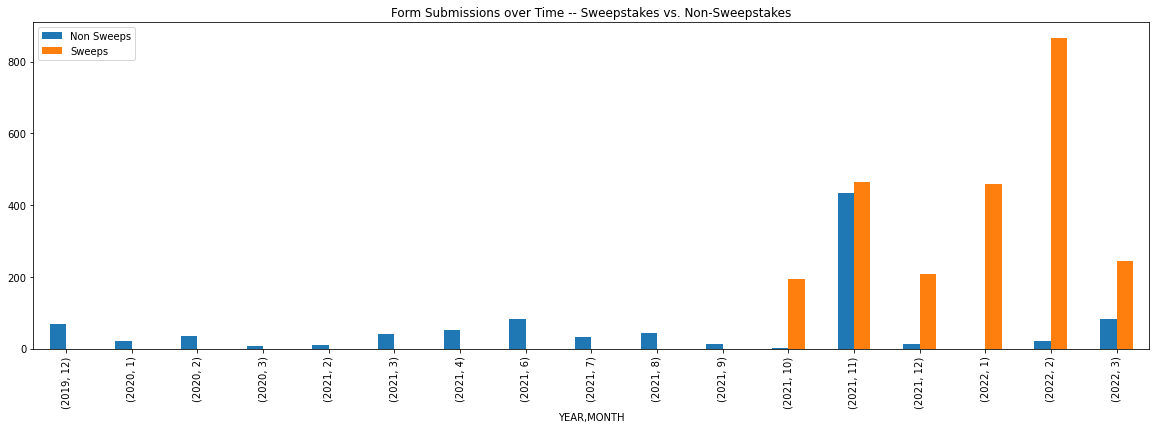

In [86]:
merged_forms.plot.bar(figsize=(20, 6), title="Form Submissions over Time -- Sweepstakes vs. Non-Sweepstakes")

We note a __large spike in sweepstakes form submissions__ in February 2022.  There may have been a sweepstakes event around that attracted much attention from fans and sponsors.  Another important note -- as we recieved this data from Colin around mid-March, the data shown for that month may be only partially complete.  

## Market Basket Analysis by Product

Next, we'll return to our merchandise dataset to perform __market basket analysis__ -- the underlying algorithm will generate association rules that dictate which products are often purchased together.  We can use the strongest association rules to help make recommendations to Colin and the team about how to drive merchandise sales.

First, we'll perform this analysis by __individual product__ -- we need to create a __sparse dataframe__ with all products __one-hot encoded__, so that the data is in the correct form to be ingested by the apriori algorithm.

In [87]:
merch_by_product = merch_df.copy()
merch_by_product["ProductName/Description"] = merch_by_product["ProductName/Description"].str.strip()
merch_by_product["OrderID"] = merch_by_product["OrderID"].astype("str")
merch_by_product["OrderID"] = merch_by_product["OrderID"].str[:-2]
merch_by_product = merch_by_product[["OrderID", "ProductName/Description", "QuantitySold", "OrderDate"]]
merch_by_product.head()

OrderID                            ProductName/Description  QuantitySold  \
0  1753028  Youth Nike De'Aaron Fox Black Sacramento Kings...             1   
1  1717858  Women's 5th & Ocean by New Era Purple Sacramen...             1   
2  1949148  Men's Fanatics Branded Black/Gray Sacramento K...             1   
3  1979693  WinCraft Sacramento Kings 14'' x 24'' Waffle G...             1   
4  1979693  Men's Fanatics Branded Heathered Charcoal Sacr...             1   

    OrderDate  
0  2021-03-17  
1  2021-01-17  
2  2021-11-23  
3  2021-12-06  
4  2021-12-06

In [88]:
basket = merch_by_product.groupby(["OrderID", "ProductName/Description"])["QuantitySold"].sum().unstack().fillna(0)
basket.head()

ProductName/Description  Adult Fanatics Branded Sacramento Kings Blackout Logo Face Covering  \
OrderID                                                                                        
1707039                                                                0.0                     
1707059                                                                0.0                     
1707062                                                                0.0                     
1707160                                                                0.0                     
1707161                                                                0.0                     

ProductName/Description  Adult Fanatics Branded Sacramento Kings Camo Duo Face Covering 2-Pack  \
OrderID                                                                                          
1707039                                                                0.0                       
1707059                                                                0.0                       
1707062                                                                0.0                       
1707160                                                                0.0                       
1707161                                                                0.0                       

ProductName/Description  Adult Fanatics Branded Sacramento Kings Cloth Face Covering - MADE IN USA  \
OrderID                                                                                              
1707039                                                                0.0                           
1707059                                                                0.0                           
1707062                                                                0.0                           
1707160                                                                0.0                           
1707161                                                                3.0                           

ProductName/Description  Adult Fanatics Branded Sacramento Kings Team Logo Face Covering 3-Pack  \
OrderID                                                                                           
1707039                                                                0.0                        
1707059                                                                0.0                        
1707062                                                                0.0                        
1707160                                                                0.0                        
1707161                                                                0.0                        

ProductName/Description  Adult Sacramento Kings FOCO Cloth Face Covering 3-Pack  \
OrderID                                                                           
1707039                                                                0.0        
1707059                                                                0.0        
1707062                                                                0.0        
1707160                                                                0.0        
1707161                                                                0.0        

ProductName/Description  Black Sacramento Kings 15oz. Coffee Mug Set  \
OrderID                                                                
1707039                                                          0.0   
1707059                                                          0.0   
1707062                                                          0.0   
1707160                                                          0.0   
1707161                                                          0.0   

ProductName/Description  Black Sacramento Kings 15oz. Personalized Stealth Bistro Mug  \
OrderID                                                

In [89]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets = basket.applymap(encode_units)
frequent_itemsets = apriori(basket_sets, min_support=0.0015, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules.sort_values(by="confidence", ascending=False).head(10)

antecedents  \
2  (Women's DKNY Sport Purple Sacramento Kings Br...   
1  (Women's G-III 4Her by Carl Banks Purple Sacra...   
0  (Adult Fanatics Branded Sacramento Kings Camo ...   

                                         consequents  antecedent support  \
2  (Women's WEAR by Erin Andrews Black Sacramento...            0.003449   
1  (Women's 5th & Ocean by New Era Purple Sacrame...            0.004188   
0  (Adult Fanatics Branded Sacramento Kings Team ...            0.007637   

   consequent support   support  confidence        lift  leverage  conviction  
2            0.004435  0.001971    0.571429  128.857143  0.001956    2.322986  
1            0.006652  0.002217    0.529412   79.588235  0.002189    2.110865  
0            0.016507  0.003942    0.516129   31.268175  0.003816    2.032553

We can see that the algorithm has found a association rule linking different __mask items__ together, as well as a couple of rules linking __women's products__ together, all with sufficient confidence (over 50%).  However, all possible rules have __very low support__ (barely over 0.1%) -- despite the good confidence scores, these rules may have too low support to actually have significance if this dataset were to be expanded.  For a different approach, we will try the same analysis using __product categories__ instead.

## Market Basket Analysis by Product Category

In [90]:
merch_by_category = merch_df.copy()
merch_by_category["ProductCategory"] = merch_by_category["ProductCategory"].str.strip()
merch_by_category["OrderID"] = merch_by_category["OrderID"].astype("str")
merch_by_category["OrderID"] = merch_by_category["OrderID"].str[:-2]
merch_by_category = merch_by_category[["OrderID", "ProductCategory", "QuantitySold", "OrderDate"]]
merch_by_category.head()

OrderID ProductCategory  QuantitySold   OrderDate
0  1753028             JER             1  2021-03-17
1  1717858             TEE             1  2021-01-17
2  1949148             SWT             1  2021-11-23
3  1979693             EQU             1  2021-12-06
4  1979693             SWT             1  2021-12-06

In [91]:
basket2 = merch_by_category.groupby(["OrderID", "ProductCategory"])["QuantitySold"].sum().unstack().fillna(0)
basket_sets2 = basket2.applymap(encode_units)
frequent_itemsets2 = apriori(basket_sets2, min_support=0.001, use_colnames=True)
rules2 = association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.5)
rules2.sort_values(by="confidence", ascending=False).head(10)

antecedents consequents  antecedent support  consequent support  \
15       (CAR, PNT)       (TEE)            0.001232            0.351564   
27       (SHR, SWT)       (TEE)            0.001232            0.351564   
28       (SHU, SHT)       (TEE)            0.001478            0.351564   
13       (BED, PNT)       (TEE)            0.001478            0.351564   
16       (PNT, COL)       (TEE)            0.001478            0.351564   
6        (CAR, SWT)       (ACC)            0.001725            0.087953   
32  (JER, HAT, SWT)       (TEE)            0.001725            0.351564   
10       (ACC, PNT)       (TEE)            0.002464            0.351564   
36  (PNT, JAC, SWT)       (TEE)            0.002217            0.351564   
34  (SOC, HAT, SWT)       (TEE)            0.002217            0.351564   

     support  confidence      lift  leverage  conviction  
15  0.001232    1.000000  2.844429  0.000799         inf  
27  0.001232    1.000000  2.844429  0.000799         inf  
28  0.001232    0.833333  2.370357  0.000712    3.890613  
13  0.001232    0.833333  2.370357  0.000712    3.890613  
16  0.001232    0.833333  2.370357  0.000712    3.890613  
6   0.001232    0.714286  8.121248  0.001080    3.192166  
32  0.001232    0.714286  2.031735  0.000626    2.269525  
10  0.001725    0.700000  1.991100  0.000858    2.161452  
36  0.001478    0.666667  1.896286  0.000699    1.945307  
34  0.001478    0.666667  1.896286  0.000699    1.945307

We now have more association rules to choose fron, but note that many of them have the __"TEE" category__ as a consequent -- since tee-shirts are the most popular product by a wide margin, it doesn't seem reasonable to assume that tee shirt sales are driven by any of the antecedents listed (all of which are significantly less popular).  That said, the remaining two rules could be a decent starting point for product recommendations to customers.

## Tickets Dataset

Finally, we return once more to our tickets dataset, where we will parse the Fox Sports game log for the Kings, in order to add to our next visualization.

In [92]:
df_ticket = pd.read_csv("Fanatics_Ticket Purchases Since 2018-19.csv")
df_ticket.shape

(34656, 11)

## Parsing Fox Sports

The following functions defined below will help us parse the __Fox Sports game log__, which will allow us to create dataframes for games that occurred during the preseason and regular season.  This will also allow us to analyze more game-related features (opposing team, point difference, etc.) in relation to ticket or merchandise sales, should we decide to do so.

__NOTE:__ Some of the preseason pages on Fox Sports were down at the time of submission, so the below functions may not run correctly -- we're currently looking into alternative ways to scrape this data.

In [93]:
def log_gene(year,seasontype='regular'):
    #the year goes up, 17 means 1718
    sign = 1
    if seasontype == 'preseason' or seasontype=='pre':
        sign=3
    return "https://www.foxsports.com/nba/sacramento-kings-team-game-log?season="+str(year)+"&category=SCORING&seasonType="+str(sign)
def rank_gene(year,seasontype='regular',groupby='conderence'):
    #the year goes down, 17 means 1617
    st='https://www.espn.com/nba/standings/_'
    if seasontype=='pre':
        st+='/seasontype/pre'
    st+='/season/'+str(year)
    if groupby=='league' or groupby=='division':
        st+='/group/'+groupby
    return st
def cleans(x):
    lis=list(x)
    while lis[0] in [str(p) for p in list(range(10))]+['y',' ','e','-','x','z','*']:
        lis=lis[1:]
    return ''.join(lis)

In [94]:
#division dictionary
URL=rank_gene(2018,groupby='league')
r=requests.get(URL)
df_list = pd.read_html(r.text)
li=list(df_list[0].columns)+list(df_list[0].iloc[:,0])
li_renew=[cleans(x) for x in li]
league_2018=[x[:3] for x in li_renew]
URL=rank_gene(2018,groupby='division')
r=requests.get(URL)
df_list = pd.read_html(r.text)
team_dic={}
for x in league_2018:
    team_dic[x]=None
df=df_list[0]
div=list(df.iloc[[0,6,12],0])
df=df.drop(labels=[0,6,12],axis=0)
li=df.iloc[:,0]
li_renew=[cleans(x) for x in li]
tea=[x[:3] for x in li_renew]
for i in range(3):
    for j in range(i*5,i*5+5):
        team_dic[tea[j]]=['eastern',div[i]]
df=df_list[2]
div=list(df.iloc[[0,6,12],0])
df=df.drop(labels=[0,6,12],axis=0)
li=df.iloc[:,0]
li_renew=[cleans(x) for x in li]
tea=[x[:3] for x in li_renew]
for i in range(3):
    for j in range(i*5,i*5+5):
        team_dic[tea[j]]=['western',div[i]]

In [95]:
game_log={}
game_log['regular']={};game_log['preseason']={}
for i in range(2018,2022):
    URL=log_gene(i)
    r=requests.get(URL)
    df_list = pd.read_html(r.text)
    df = df_list[0]
    df2=df.drop(df.columns[3:],axis=1)
    s=[(str(i)+'-'+x[:2]+'-'+x[-2:]) if int(x[:2])>=10 else (str(i+1)+'-'+x[:2]+'-'+x[-2:]) for x in df2.Date]
    df2.insert(0,'date',s)
    df2['eventseason']=i
    df2['place'] = df2.apply(lambda row:'home' if row.Opponent[0]=='v' else 'away', axis=1)
    df2['opponent']=df2['Opponent'].str.slice(-3,)
    df2['result']=df2['Result'].str.slice(0,1)
    df2['score']=df2['Result'].str.slice(2,)
    df2['gametype']='regular'
    df2['score'].fillna(value='0-0', inplace=True)
    df2['result'].fillna(value='C',inplace=True)
    s=['cancel' if x=='0-0' else 'normal' for x in df2.score]
    df2['state']=s
    s=[int(x.split('-')[0])-int(x.split('-')[1])  for x in df2['score']]
    df2['net_score']=s
    df_final=df2.drop(df2.columns[[1,2,3]],axis=1)
    game_log['regular'][i]=df_final
    URL=log_gene(i,'pre')
    r=requests.get(URL)
    df_list = pd.read_html(r.text)
    df = df_list[0]
    df2=df.drop(df.columns[3:],axis=1)
    s=[(str(i)+'-'+x[:2]+'-'+x[-2:]) if int(x[:2])>9 else (str(i+1)+'-'+x[:2]+'-'+x[-2:]) for x in df2.Date]
    df2.insert(0,'date',s)
    df2['eventseason']=i
    df2['place'] = df2.apply(lambda row:'home' if row.Opponent[0]=='v' else 'away', axis=1)
    df2['opponent']=df2['Opponent'].str.slice(-3,)
    df2['result']=df2['Result'].str.slice(0,1)
    df2['score']=df2['Result'].str.slice(2,)
    df2['gametype']='preseason'
    s=[int(x.split('-')[0])-int(x.split('-')[1])  for x in df2['score']]
    df2['net_score']=s
    df_final=df2.drop(df2.columns[[1,2,3]],axis=1)
    game_log['preseason'][i]=df_final

In [96]:
league_rank={}
league_rank['regular']={};league_rank['preseason']={}
for i in range(2018,2022):
    URL=rank_gene(i,groupby='league')
    r=requests.get(URL)
    df_list = pd.read_html(r.text)
    li=list(df_list[0].columns)+list(df_list[0].iloc[:,0])
    li_renew=[cleans(x) for x in li]
    li_final=[x[:3] for x in li_renew]
    league_rank['regular'][i]=li_final
    URL=rank_gene(i,'pre','league')
    r=requests.get(URL)
    df_list = pd.read_html(r.text)
    li=list(df_list[0].columns)+list(df_list[0].iloc[:,0])
    li_renew=[cleans(x) for x in li]
    li_final=[x[:3] for x in li_renew]
    league_rank['preseason'][i]=li_final

In [97]:
df_2=df_ticket.groupby(['EVENTDATE']).sum()

In [98]:
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (14,10)
%matplotlib inline
ind=list(df_2.index>'2020-03-01').index(True)
x=pd.to_datetime(df_2.index)
y=df_2.NUMBEROFSEATS
x1=pd.to_datetime(list(df_2.index[:ind]))
x2=pd.to_datetime(list(df_2.index[ind-1:]))
y1=list(df_2.NUMBEROFSEATS)[:ind]
y2=list(df_2.NUMBEROFSEATS)[ind-1:]
fig, ax = plt.subplots()
ax.set_title('Ticket Sales Since 2018')
ax.plot(x1,y1)
ax.plot(x2,y2,linestyle='dashed')
#ax.set_xticks(ax.get_xticks()[::10])
plt.gcf().autofmt_xdate()
crs = mplcursors.cursor(ax,hover=True)
crs.connect("add", lambda sel: sel.annotation.set_text(
    'date:{},seat:{}'.format(x1[int(sel.index)] if sel.target[0]<=18322 else x2[int(sel.index)],y1[int(sel.index)] if sel.target[0]<=18322 else y2[int(sel.index)])))
for i in [2018,2020,2021]:
    d1=game_log['regular'][i].iloc[0,0];d2=game_log['regular'][i].iloc[-1,0]
    ax.axvspan(pd.to_datetime(d1),pd.to_datetime(d2), color='red', alpha=0.1)
    plt.annotate(s='', xy=(pd.to_datetime(d1),100), xytext=(pd.to_datetime(d2),100), arrowprops=dict(arrowstyle='<->'))
    #plt.annotate(s='', xy=(pd.to_datetime('2019-05-08'),665), xytext=(pd.to_datetime('2020-07-08'),665), arrowprops=dict(arrowstyle='<->'))
    plt.text(pd.to_datetime(d1),120,'regular\nseason')
for i in [2018,2019,2020,2021]:
    d1=game_log['preseason'][i].iloc[0,0];d2=game_log['preseason'][i].iloc[-1,0]
    ax.axvspan(pd.to_datetime(d1),pd.to_datetime(d2), color='green', alpha=0.1)
    plt.annotate(s='', xy=(pd.to_datetime(d1),200), xytext=(pd.to_datetime(d2),200), arrowprops=dict(arrowstyle='<->'))
    plt.text(pd.to_datetime(d1),220,'pre\nseason')
ind1=list(game_log['regular'][2019].state).index('cancel');ind2=list(game_log['regular'][2019].state)[::-1].index('cancel')
d1=game_log['regular'][2019].date[0];d2=game_log['regular'][2019].date[ind1-1]
d3=list(game_log['regular'][2019].date)[-ind2-1];d4=list(game_log['regular'][2019].date)[-1]
ax.axvspan(pd.to_datetime(d1),pd.to_datetime(d2), color='red', alpha=0.1)
ax.axvspan(pd.to_datetime(d3),pd.to_datetime(d4), color='red', alpha=0.1)
plt.annotate(s='', xy=(pd.to_datetime(d1),100), xytext=(pd.to_datetime(d2),100), arrowprops=dict(arrowstyle='<->'))
plt.annotate(s='', xy=(pd.to_datetime(d3),100), xytext=(pd.to_datetime(d4),100), arrowprops=dict(arrowstyle='<->'))
plt.text(pd.to_datetime(d1),120,'regular\nseason')
plt.text(pd.to_datetime(d3),120,'resume')
ax.axvspan(pd.to_datetime(d2),pd.to_datetime(d3), color='grey', alpha=0.1)
plt.annotate(s='', xy=(pd.to_datetime(d2),200), xytext=(pd.to_datetime(d3),200), arrowprops=dict(arrowstyle='<->'))
plt.text(pd.to_datetime(d2),220,'postpone')
plt.show()

<ipython-input-98-e63e76bebbbf>:23: MatplotlibDeprecationWarning:

The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.

<ipython-input-98-e63e76bebbbf>:29: MatplotlibDeprecationWarning:

The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.

<ipython-input-98-e63e76bebbbf>:36: MatplotlibDeprecationWarning:

The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.

<ipython-input-98-e63e76bebbbf>:37: MatplotlibDeprecationWarning:

The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.

<ipython-input-98-e63e76bebbbf>:41: MatplotlibDeprecationWarning:

The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; sup

The above visualization shows the trend of ticket sales from the __2018-19 season to the present day.__  The grey vertical stripes represent __preseason games__, while the red stripes represent __regular season games__, and the white space represents __offseason times__.  The annotations also account for the __postponement of the 2019-20 season due to the start of the pandemic__ -- __pre-pandemic games are shown by the blue line__, while the rest are shown by the __dotted orange line__.

## Next Steps

At this point, the team is quite finished with EDA-related tasks -- a couple of team members are finishing insights into correlation between emails, tickets, and merchandise, but beyond that the team is focused on building the final presentation for Colin and the team -- this includes storytelling and organization, refining the visualizations to be included, and isolating the business cases for our analysis.